In [21]:
import requests
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point, LineString
import datetime
import random
import matplotlib
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [22]:
def add_geometry_coordinates(df, columns=['x_geometry', 'y_geometry']):
    """Append centroid coordinates to GeoDataFrame 

    Parameters
    ----------
    df : GeoDataFrame
        _description_
    columns : list, optional
        Names for the coordinates columns, by default ['x_geometry', 'y_geometry']

    Returns
    -------
    GeoDataFrame
        GeoDataFrame with centroid coordinates columns.
    """
    df = df.copy()

    # if the geometry is not a point...
    centroids = df['geometry'].apply(lambda g: g.centroid)

    df[columns[0]] = centroids.apply(lambda g: g.coords[0][0])
    df[columns[1]] = centroids.apply(lambda g: g.coords[0][1])
    return df
def nearest(one, nbrs):

    try:
        # assert df_many.index.is_unique
        assert one.index.is_unique
    except AssertionError:
        msg = 'index of one and many should not contain duplicates'
        print(msg)

    df_one = add_geometry_coordinates(one.copy(), columns=['x_geometry', 'y_geometry'])

    # x = df_many[['x_geometry','y_geometry']].values
    y = df_one[['x_geometry', 'y_geometry']].values

    distances, indices = nbrs.kneighbors(y)

    indices = pd.DataFrame(indices)
    distances = pd.DataFrame(distances)
    indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
        columns={'level_0': 'ix_one', 'level_1': 'rank'})
    indices

    return indices

# Test API with more OD

In [23]:

links = gpd.read_file('../../../Downloads/S1/network/links.geojson')
links['time'] = links['length']/links['speedau']
links['time'] = links['time']*3600

mean_speed = (links['speedau']*links['length']).mean()/links['length'].mean()
links['time_ff'] = links['length']/mean_speed
links['time_ff'] = links['time_ff']*3600

links[np.isfinite(links['time'])]
links = links.reset_index(drop=True)
links.index = 'link_'+links.index.astype(str)
links['length'] = links['length']*1000
#links

In [24]:
zones = gpd.read_file('../../../Downloads/base/zones/Zat_TC.geojson')
centroid = zones.copy()
centroid['geometry'] = centroid.centroid

In [25]:
nodes = gpd.read_file('../../../Downloads/S1/network/nodes.geojson')
nodes_set = set(links['i'].unique()).union(set(links['j'].unique()))
nodes = nodes[nodes['ID'].isin(nodes_set)]
nodes = nodes.set_index('ID')
nodes = nodes.reset_index()
node_dict = nodes['ID'].to_dict()
nodes = nodes.set_index('ID')


In [26]:
from sklearn.neighbors import NearestNeighbors
x = nodes[['X', 'Y']].values
nbrs = NearestNeighbors(n_neighbors=1, algorithm='ball_tree').fit(x)
neigh = nearest(centroid,nbrs)

In [27]:

node_index = neigh['index_nn'].to_dict()
centroid['node_index'] = centroid.index.map(node_index.get)
centroid['node_index'] = centroid['node_index'].apply(lambda x: node_dict.get(x))

In [28]:
centroid[centroid['node_index'].isnull()]

,xcentro,ycentro,ZATTC,Population,ARRON,geometry,node_index


In [29]:
random.seed(74)

In [30]:
random.seed(74)
random_list = random.sample(range(0, len(centroid)), 251)
centroid['set'] = 'test'
centroid.loc[random_list,'set'] = 'train'

In [31]:
centroid = centroid.drop_duplicates('node_index')

In [32]:
len(centroid)

885

In [33]:
len(centroid[centroid['set']=='train'])

250

In [34]:
#%matplotlib notebook
#f, ax = plt.subplots(figsize=(10,8))
#links.plot(ax=ax,alpha=0.2)
#nodes_test.plot(ax=ax,color='g')
#nodes_train.plot(ax=ax,color='r')


In [35]:
# variogramme pour changer la fonction weight ou tester des fonctions.
# utiliser un model et un residue. regarder varuigram sur les residue
# Entrainer sur Y  = Dijktra_20kmh - dijktra_reelle (prendre la vitesse moyenmne sur tout le reseau.)

# OD on road model

In [36]:
from quetzal.engine.road_pathfinder import sparse_matrix, parallel_dijkstra
from scipy.sparse.csgraph import dijkstra

In [37]:
def road_routing(origin,destination,mat,node_index,dijkstra_limit=np.inf):
    # simple routing scipy wrapper for GTFS routing
    #
    index_node = {v: k for k, v in node_index.items()}
    # liste des origines pour le dijkstra
    origin_sparse = [node_index[x] for x in origin]
    
    # dijktra on the road network from node = incices to every other nodes.
    # from b to a.
    dist_matrix, predecessors = dijkstra(
        csgraph=mat,
        directed=True,
        indices=origin_sparse,
        return_predecessors=True,
        limit=dijkstra_limit
    )

    dist_matrix = pd.DataFrame(dist_matrix)
    dist_matrix.index = origin
    # filtrer. on garde seulement les destination d'intéret
    destination_sparse = [node_index[x] for x in destination]
    dist_matrix = dist_matrix[destination_sparse]
    dist_matrix = dist_matrix.rename(columns=index_node)
    
    return dist_matrix

# format data

In [38]:
def format_data(od_time,od_timeff,od_dist,nodes):
    df = od_time.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
    routing_dict = od_dist.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'dist'})['dist'].to_dict()
    timeff_dict = od_timeff.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time_ff'})['time_ff'].to_dict()
    geom_dict  = nodes['geometry'].to_dict()
    df['o_geometry'] = df['origin'].apply(lambda x: geom_dict.get(x))
    df['d_geometry'] = df['destination'].apply(lambda x: geom_dict.get(x))
    df['o_lon'] = df['o_geometry'].apply(lambda p: p.x)
    df['o_lat'] = df['o_geometry'].apply(lambda p: p.y)
    df['d_lon'] = df['d_geometry'].apply(lambda p: p.x)
    df['d_lat'] = df['d_geometry'].apply(lambda p: p.y)
    df['distance'] = ((df['o_lon']-df['d_lon'])**2 + (df['o_lat']-df['d_lat'])**2)**0.5
    df['route_distance'] = df.index.map(routing_dict.get)
    df['time_ff'] = df.index.map(timeff_dict.get)
    df['residual'] = df['time_ff']-df['time']
    df['lat_diff'] = df['o_lat']-df['d_lat']
    df['lon_diff'] = df['o_lon']-df['d_lon']
    X = df[['o_lon','o_lat','d_lon','d_lat','distance','route_distance','lon_diff','lat_diff']]
    Y = df[['time','time_ff','residual']]
    return X, Y

In [39]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid[centroid['set']=='train']['node_index'].values,
             centroid[centroid['set']=='train']['node_index'].values,
             mat,
             indices)

mat,indices = sparse_matrix(links[['i','j','time_ff']].values)
od_timeff_quebec = road_routing(centroid[centroid['set']=='train']['node_index'].values,
             centroid[centroid['set']=='train']['node_index'].values,
             mat,
             indices)

mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid[centroid['set']=='train']['node_index'].values,
             centroid[centroid['set']=='train']['node_index'].values,
             mat,
             indices)

od_time_quebec.mean().mean()/60

25.39831027356765

In [20]:
X_train, y_train = format_data(od_time_quebec,od_timeff_quebec,od_dist_quebec,nodes)


In [21]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid[centroid['set']=='test']['node_index'].values,
             centroid[centroid['set']=='test']['node_index'].values,
             mat,
             indices)

mat,indices = sparse_matrix(links[['i','j','time_ff']].values)
od_timeff_quebec = road_routing(centroid[centroid['set']=='test']['node_index'].values,
             centroid[centroid['set']=='test']['node_index'].values,
             mat,
             indices)

mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid[centroid['set']=='test']['node_index'].values,
             centroid[centroid['set']=='test']['node_index'].values,
             mat,
             indices)
od_time_quebec.mean().mean()/60

24.98944464946428

In [22]:
X_test, y_test = format_data(od_time_quebec,od_timeff_quebec,od_dist_quebec,nodes)

In [23]:
print(len(X_train)**0.5)

250.0


In [24]:
print(len(X_test),len(X_train),len(X_train)/len(X_test))

403225 62500 0.15500031000062


NameError: name 'X' is not defined

# using actual OD to train

In [40]:
mat,indices = sparse_matrix(links[['i','j','time']].values)
od_time_quebec = road_routing(centroid['node_index'].values,
                centroid['node_index'].values,
                 mat,
                 indices)

mat,indices = sparse_matrix(links[['i','j','time_ff']].values)
od_timeff_quebec = road_routing(centroid['node_index'].values,
                centroid['node_index'].values,
                 mat,
                 indices)

mat,indices = sparse_matrix(links[['i','j','length']].values)
od_dist_quebec = road_routing(centroid['node_index'].values,
                centroid['node_index'].values,
                 mat,
                 indices)
od_time_quebec.mean().mean()/60


25.12917586696319

In [41]:
X, y = format_data(od_time_quebec,od_timeff_quebec,od_dist_quebec,nodes)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=1-(250**2)/len(centroid)**2, random_state=42)

In [42]:
print(len(X_test),len(X_train),len(X_train)/len(X_test))

720725 62500 0.08671823511047903


In [43]:
print(len(X_train)**0.5)

250.0


# KNN

In [24]:
%%time
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(weights='distance',algorithm='ball_tree', n_neighbors=5,)
neigh.fit(X_train.values, y_train['residual'].values)
pred_res = neigh.predict(X_test.values)

CPU times: user 57.2 s, sys: 330 ms, total: 57.6 s
Wall time: 57.6 s


In [25]:



predictions = y_test['time_ff'] - pred_res
errors = abs(predictions - y_test['time'])
MAPE = errors/y_test['time']

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors)/60, 2), 'mins.')

Mean Absolute Error: 1.03 mins.


In [31]:
x = y_test['time'].values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


In [32]:
metric=pd.DataFrame()
model_name = 'KNN'
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metric.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metric.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metric.loc[model_name,'r2'] = r2
metric.loc[model_name,'slope'] = slope
metric.loc[model_name,'diff_mean'] = mean
metric.loc[model_name,'diff_median'] = median
metric.loc[model_name,'diff_STD'] = sigma

Text(0.5, 1.0, 'comparaison temps KNN (jaune = 5% des points)')

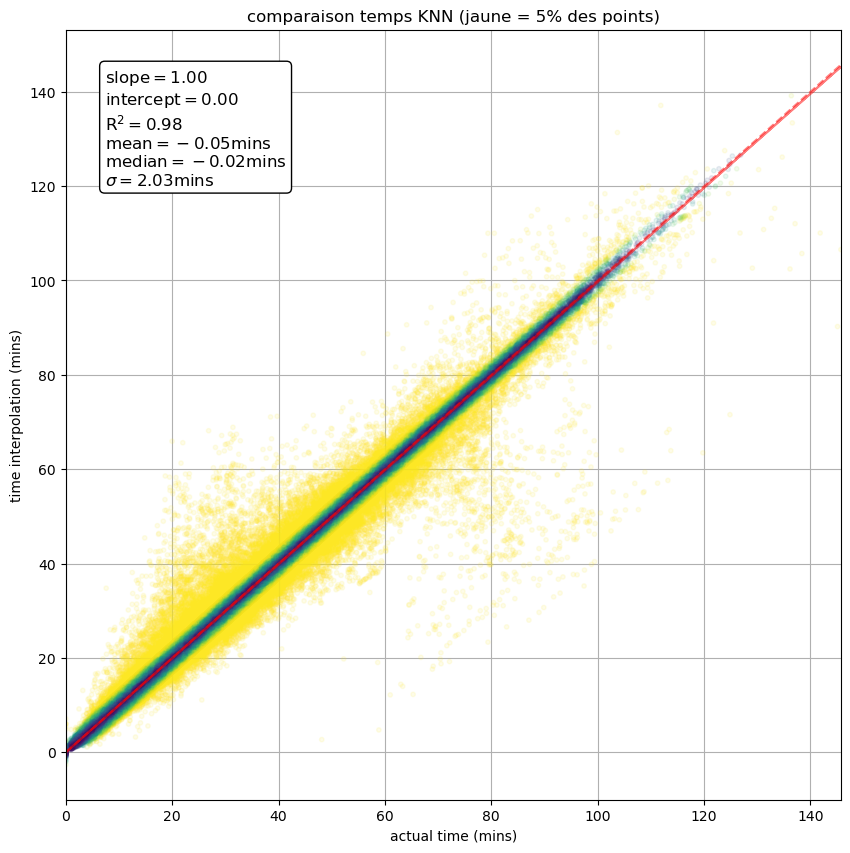

In [33]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=errors,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=errors.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
     r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps KNN (jaune = 5% des points)')


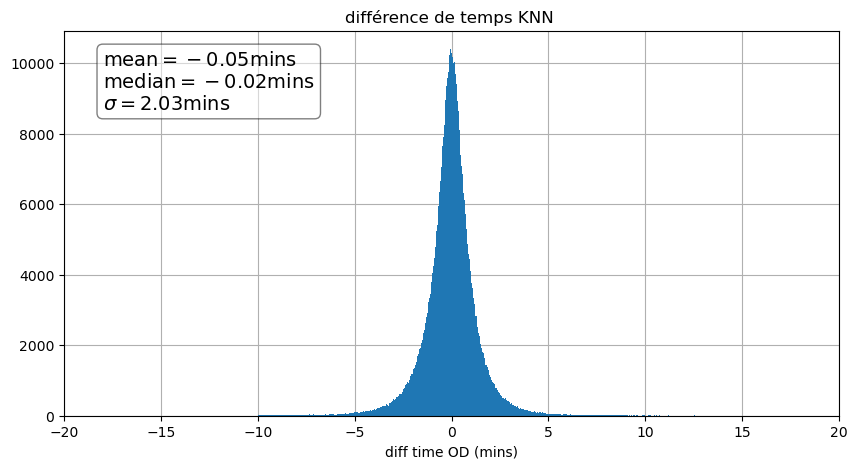

In [122]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(x-y,bins=np.linspace(-10,20, 1000))
plt.xlabel('diff time OD (mins)')
mean = np.mean(x - y)
median =np.median(x - y)
sigma = np.std(x-y)
textstr = '\n'.join((
    r'$\mathrm{mean}=%.2f$mins' % (mean, ),
    r'$\mathrm{median}=%.2f$mins' % (median, ),
    r'$\sigma=%.2f$mins' % (sigma, )))

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.title('différence de temps KNN ')
#plt.title('différence de temps (best solution - quetzal) pour chaque OD' +city+relgap)


plt.show()

Text(0.5, 1.0, 'comparaison temps knn (jaune = 95% percentille de la MAPE)')

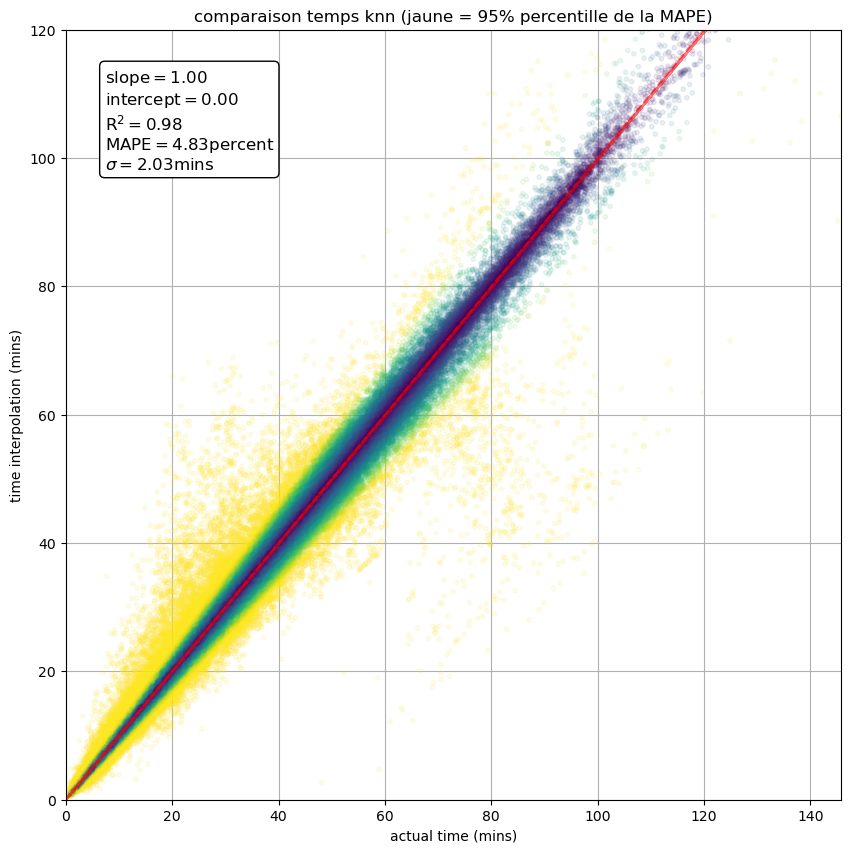

In [123]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))

plt.scatter(x,y,
            s=10,
            c=MAPE,
            norm=matplotlib.colors.Normalize(vmin=0, vmax=MAPE.quantile(0.95), clip=True),
            alpha=0.1)


maxvalue = max(max(x),max(y))
plt.plot([0,maxvalue],[0,maxvalue],'--r',alpha=0.5)
sigma = np.std(x-y)

textstr = '\n'.join((
    r'$\mathrm{slope}=%.2f$' % (slope, ),
    r'$\mathrm{intercept}=%.2f$' % (intercept, ),
    r'$\mathrm{R^2}=%.2f$' % (r2, ),
    r'$\mathrm{MAPE}=%.2f$percent' % (100*np.nanmean(MAPE[np.isfinite(MAPE)]), ),
    r'$\sigma=%.2f$mins' % (sigma, )))
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)
# place a text box in upper left in axes coords
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)
plt.plot(x,x*slope+intercept,'r',alpha=0.5)
#plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)
plt.xlim([0,120])
plt.ylim([0,120])
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('comparaison temps knn (jaune = 95% percentille de la MAPE)')


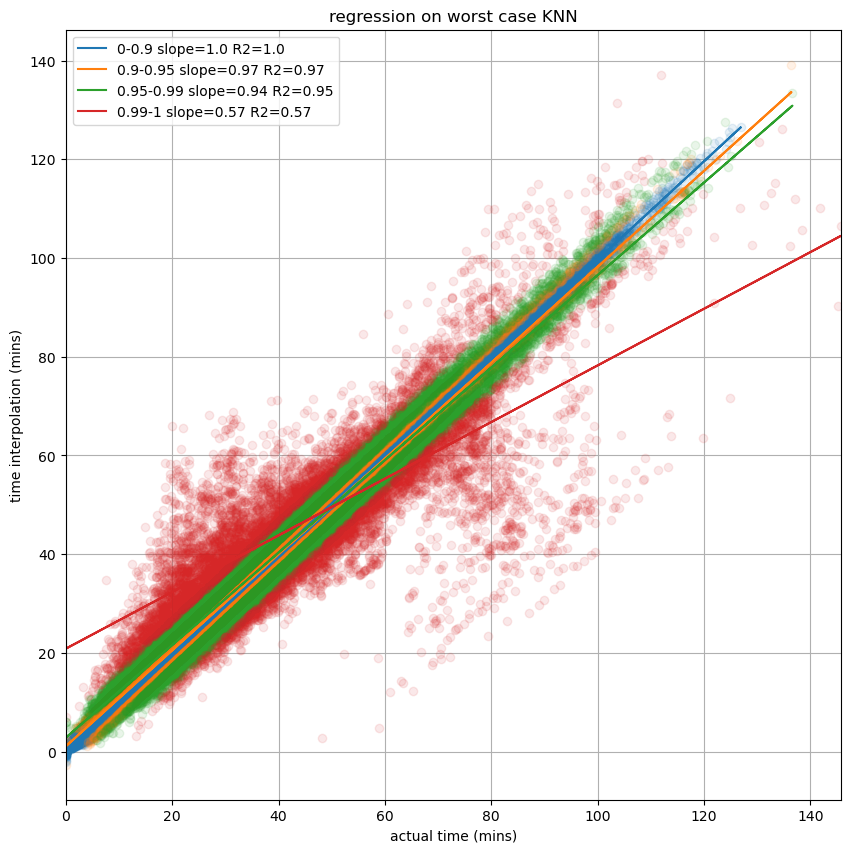

In [124]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond]['time'].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    interceptw = regr.intercept_
    label = str(quant[i]) + '-'+ str(quant[i+1]) + ' slope='+str(round(slopew,2)) + ' R2=' +str(round(r2,2))
    metric.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metric.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

    plt.scatter(xw,yw,alpha=0.1)
    line = plt.plot(xw,xw*slopew+interceptw,alpha=1,label=label)
    #plt.plot(x_worst,x_worst*slope_worst+intercept,'r',alpha=0.3)

plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([0,max(x)])
plt.xlabel('actual time (mins)')
plt.ylabel('time interpolation (mins)')
plt.title('regression on worst case KNN')
plt.legend()      

# comparaison 

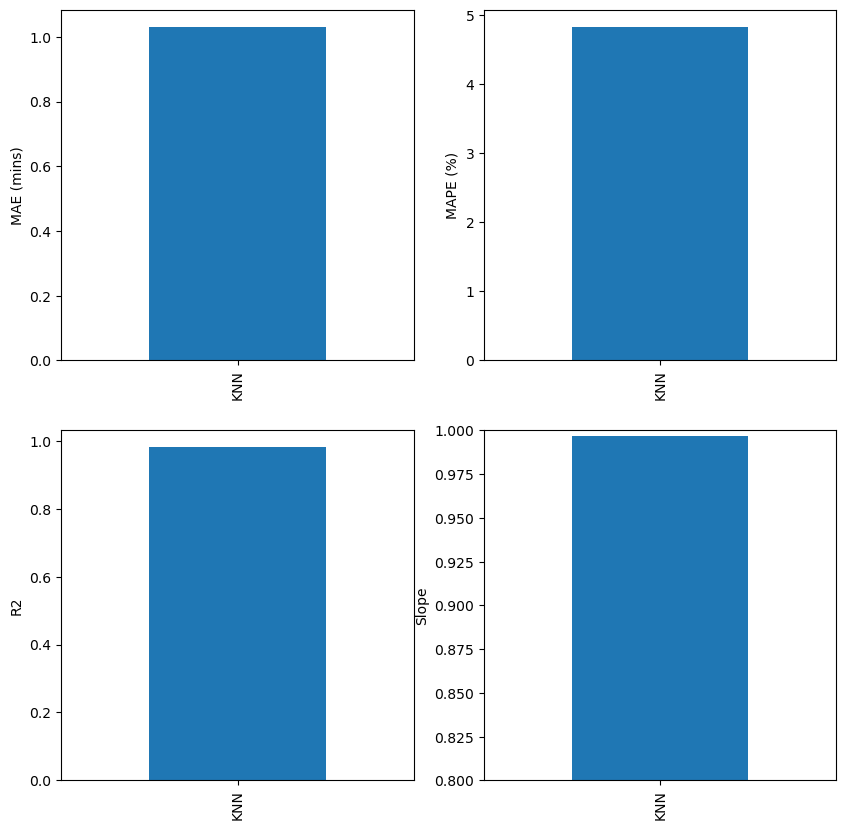

In [564]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metric['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)')
metric['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)')
metric['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2')
metric['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.8,1])
plt.show()

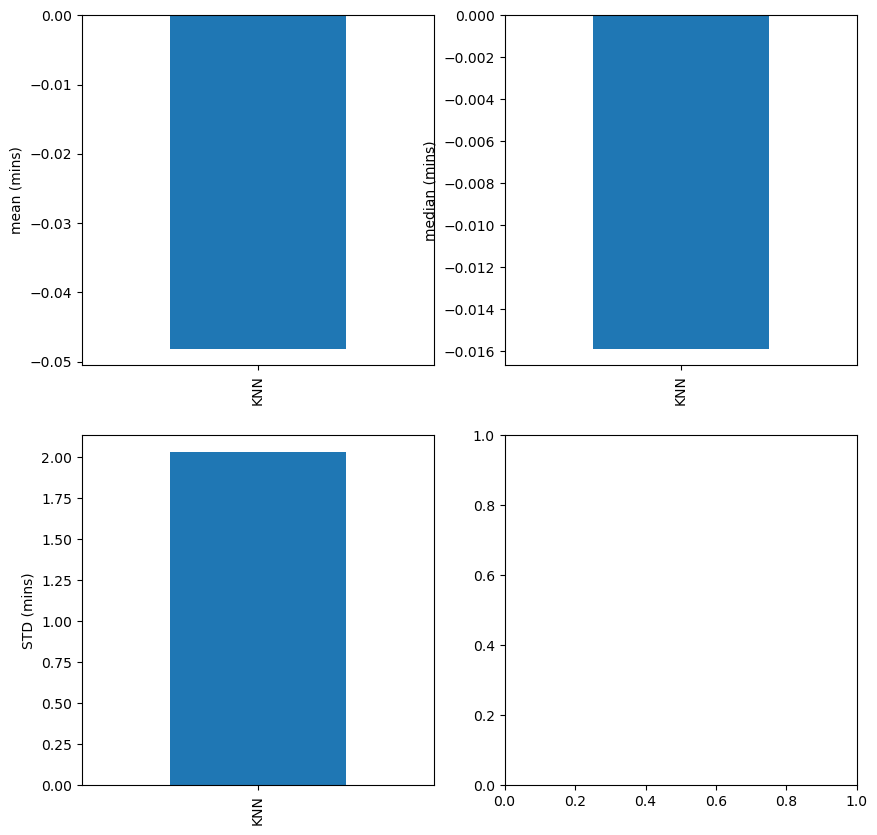

In [565]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metric['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metric['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metric['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)')
plt.show()

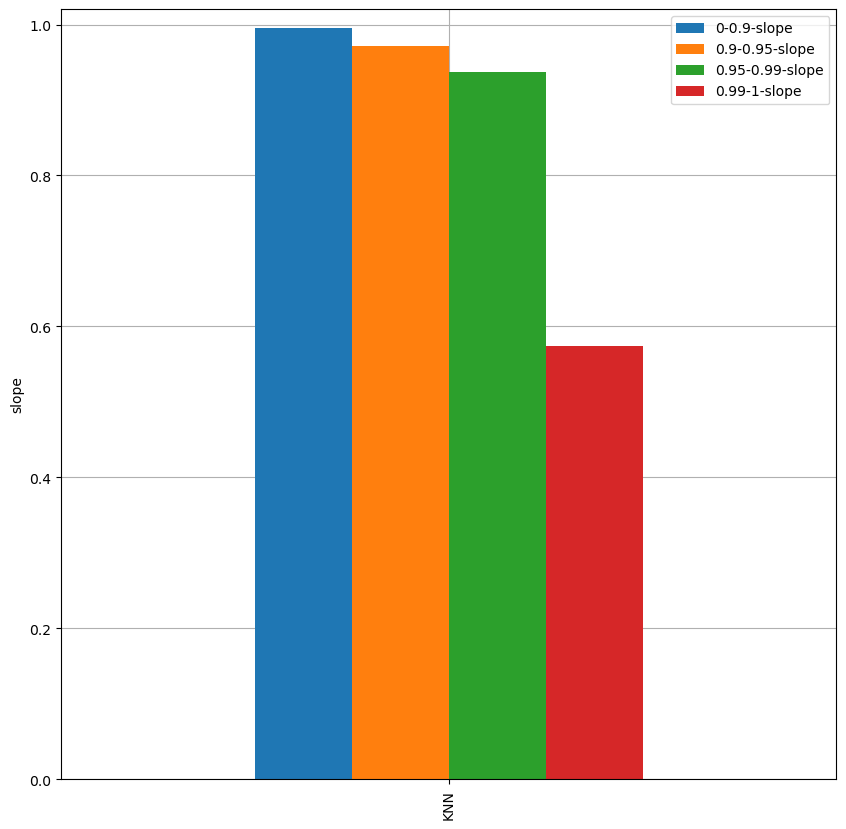

In [566]:
fig, ax = plt.subplots(figsize=(10,10))

metric[metric.columns[['-slope' in col for col in metric.columns]]].plot(ax=ax,kind='bar',ylim=[0,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

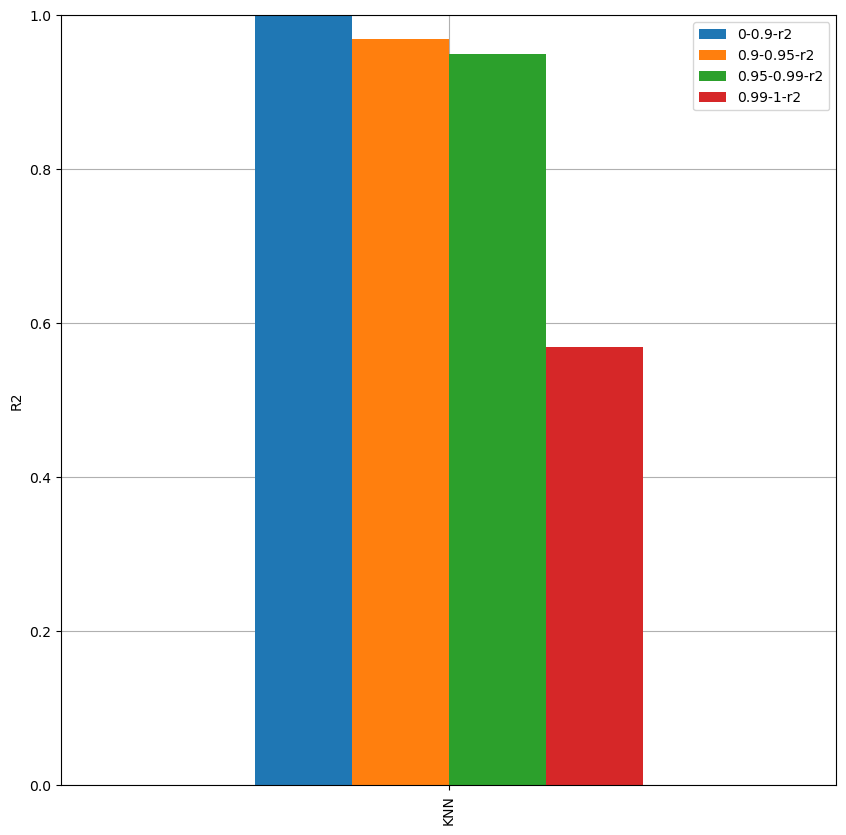

In [567]:
fig, ax = plt.subplots(figsize=(10,10))

metric[metric.columns[['-r2' in col for col in metric.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)

In [568]:
df = od_time_quebec.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
df.loc[X_test.index,'predictions']=predictions
df.loc[X_test.index,'errors']=errors
df.loc[X_test.index,'MAPE']=MAPE

In [571]:
X_test.loc[593621]

o_lon             2.280748e+05
o_lat             5.194362e+06
d_lon             2.295307e+05
d_lat             5.195765e+06
distance          2.021841e+03
route_distance    3.609593e+03
lon_diff         -1.455852e+03
lat_diff         -1.402975e+03
Name: 593621, dtype: float64

In [572]:
3531.176137/60

58.85293561666666

In [573]:
len(predictions)

720725

In [45]:
training_nodes = set(df.loc[X_train.index]['origin']).union(set(df.loc[X_train.index]['destination']))

<IPython.core.display.Javascript object>


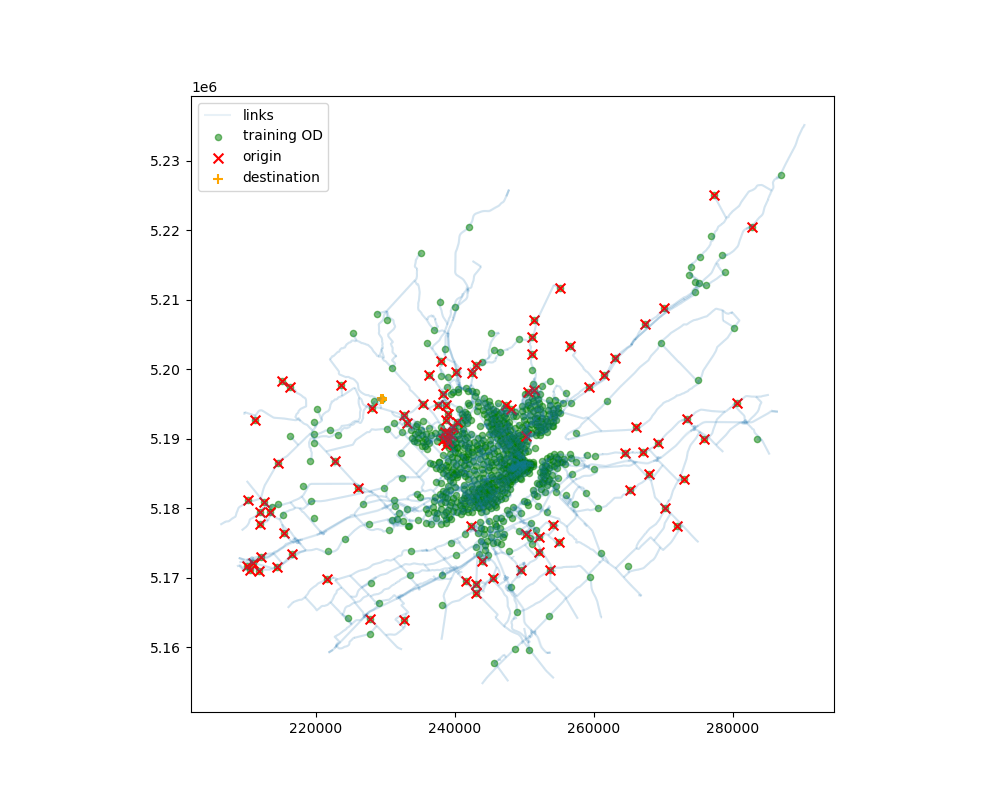

/var/folders/p9/tw29fgs17yvfs17876xjxjqh0000gn/T/ipykernel_64801/655541722.py:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nodes.loc[training_nodes].plot(ax=ax,color='g',markersize=20,alpha=0.5)


In [46]:
%matplotlib notebook
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.1)
nodes.loc[training_nodes].plot(ax=ax,color='g',markersize=20,alpha=0.5)
nodes.loc[ori].plot(ax=ax,color='red',marker='x',markersize=50)
nodes.loc[des].plot(ax=ax,color='orange',marker='+',markersize=50)

plt.legend(['links','training OD','origin','destination'])

In [55]:
X_train.columns

Index(['o_lon', 'o_lat', 'd_lon', 'o_lat', 'distance', 'route_distance',
       'lon_diff', 'lat_diff'],
      dtype='object')

In [100]:
X_train.columns[[0,1,2,3,4]].values

array(['o_lon', 'o_lat', 'd_lon', 'd_lat', 'distance'], dtype=object)

# loop

In [112]:
%%time
hdf = pd.DataFrame()
metrics = pd.DataFrame()
for param in [('all',[0,1,2,3,4,5,6,7]), ('all-no-diff',[0,1,2,3,4,5]), ('no-diff-no-dist',[0,1,2,3,5]), ('no-diff-no-route',[0,1,2,3,4]) ,('lon-lat',[0,1,2,3])]:
    model_name = 'KNN'+str(param[0])
    print(model_name)
    columns = X_train.columns[param[1]].values
    neigh = KNeighborsRegressor(weights='distance',algorithm='ball_tree', n_neighbors=5,)
    neigh.fit(X_train[columns].values, y_train['residual'].values)
    pred_res = neigh.predict(X_test[columns].values)
    
    predictions = y_test['time_ff'] - pred_res
    errors = abs(predictions - y_test['time'])
    MAPE = errors/y_test['time']

    x = y_test['time'].values/60
    y = predictions/60
    regr = linear_model.LinearRegression(fit_intercept=False)#

    regr.fit(x[:, np.newaxis], y)
    y_pred = regr.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    slope = regr.coef_[0]
    intercept=0


    hdf[model_name] = x-y
    sigma = np.std(x-y)
    mean = np.mean(x - y)
    median =np.median(x - y)

    metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
    metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
    metrics.loc[model_name,'r2'] = r2
    metrics.loc[model_name,'slope'] = slope
    metrics.loc[model_name,'diff_mean'] = mean
    metrics.loc[model_name,'diff_median'] = median
    metrics.loc[model_name,'diff_STD'] = sigma

    quant = [0,0.9,0.95,0.99,1]
    for i in range(len(quant)-1):
        cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
        yw = predictions[cond]/60
        xw = y_test[cond]['time'].values/60
        regr = linear_model.LinearRegression(fit_intercept=True)#
        regr.fit(xw[:, np.newaxis], yw)
        y_predw = regr.predict(xw[:, np.newaxis])
        r2 = r2_score(yw, y_predw)
        regr.fit(xw[:, np.newaxis], yw)
        slopew = regr.coef_[0]
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)



KNNall
KNNall-no-diff
KNNno-diff-no-dist
KNNno-diff-no-route
KNNlon-lat
CPU times: user 4min 3s, sys: 2.91 s, total: 4min 6s
Wall time: 3min 58s


In [113]:
metrics

,MAE,MAPE,r2,slope,diff_mean,diff_median,diff_STD,0-0.9-slope,0-0.9-r2,0.9-0.95-slope,0.9-0.95-r2,0.95-0.99-slope,0.95-0.99-r2,0.99-1-slope,0.99-1-r2
KNNall,1.03,4.827051,0.981581,0.996974,-0.048148,-0.015869,2.032624,0.995689,1.0,0.971223,0.97,0.936988,0.95,0.573776,0.57
KNNall-no-diff,1.00,4.653793,0.982812,0.996618,-0.034125,-0.011725,1.963617,0.995821,1.0,0.971940,0.98,0.942493,0.95,0.582439,0.58
KNNno-diff-no-dist,0.96,4.499752,0.983917,0.996901,-0.032432,-0.010265,1.900570,0.996034,1.0,0.974733,0.98,0.948192,0.95,0.597680,0.60
KNNno-diff-no-route,0.99,4.653840,0.983246,0.997062,-0.040453,-0.015243,1.939496,0.996342,1.0,0.976714,0.98,0.948481,0.95,0.606210,0.62
KNNlon-lat,0.95,4.478720,0.984874,0.998244,-0.051435,-0.018184,1.846063,0.997048,1.0,0.980792,0.98,0.959535,0.95,0.643190,0.64


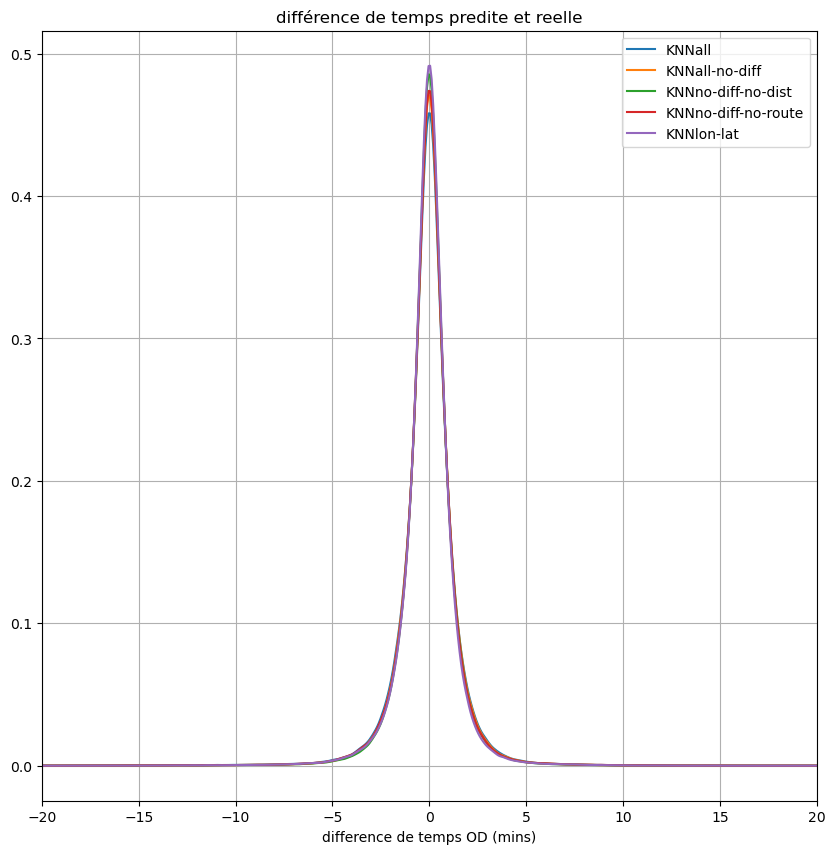

In [114]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name])
    plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
plt.legend(hdf.columns)
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

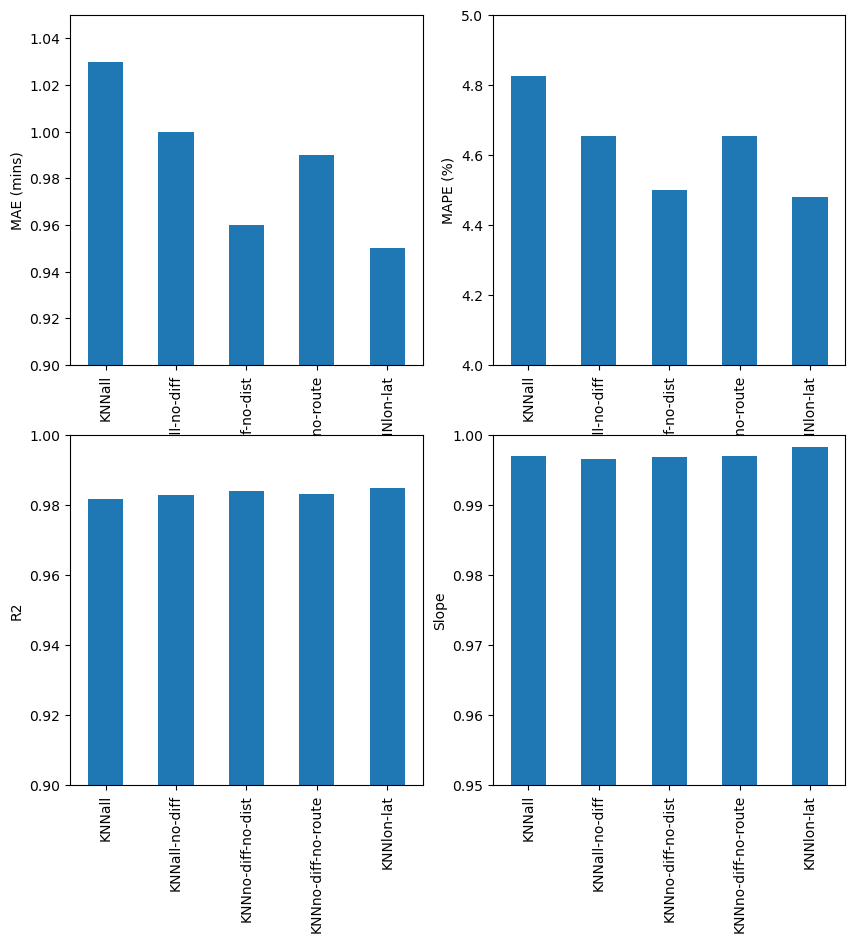

In [121]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)',ylim=[0.9,1.05])
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)',ylim=[4,5])
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2',ylim=[0.9,1])
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.95,1])
plt.show()

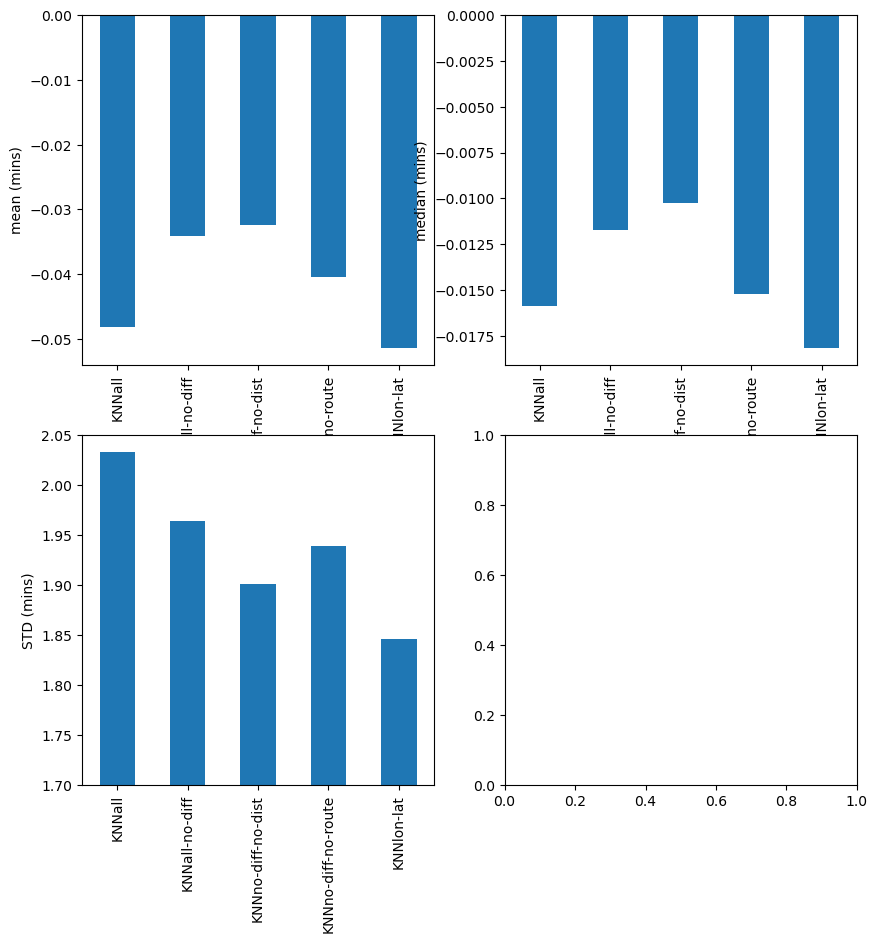

In [125]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)',ylim=[1.7,2.05])
plt.show()

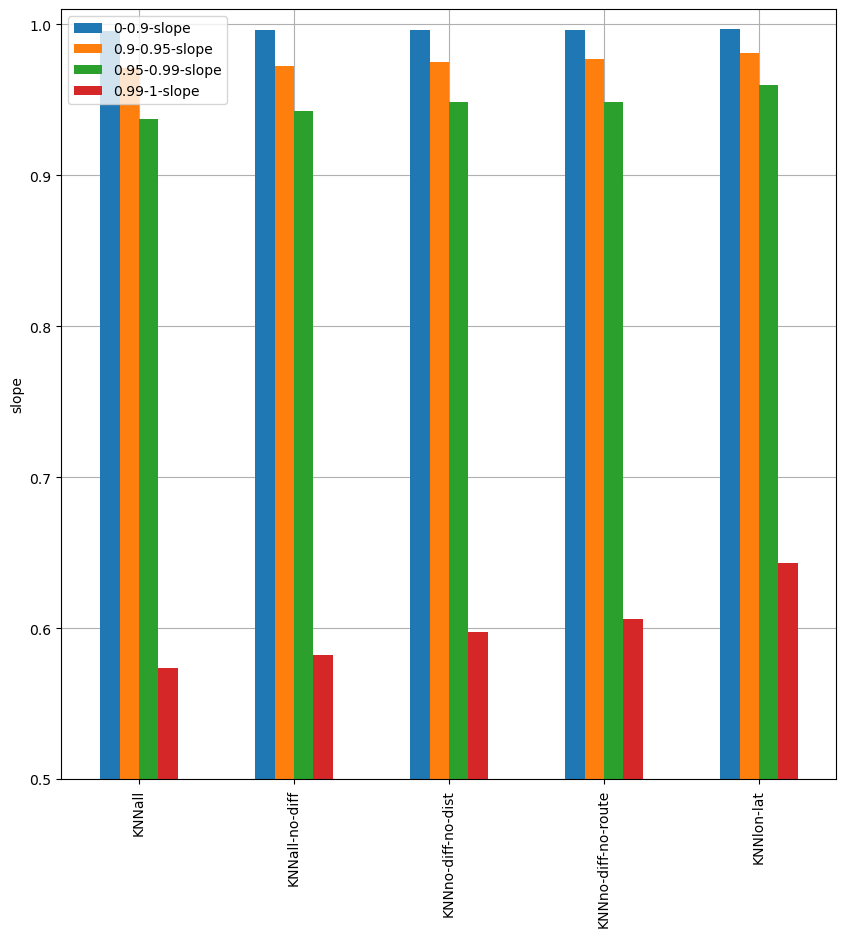

In [131]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.5,1.01])

ax.set_axisbelow(True)

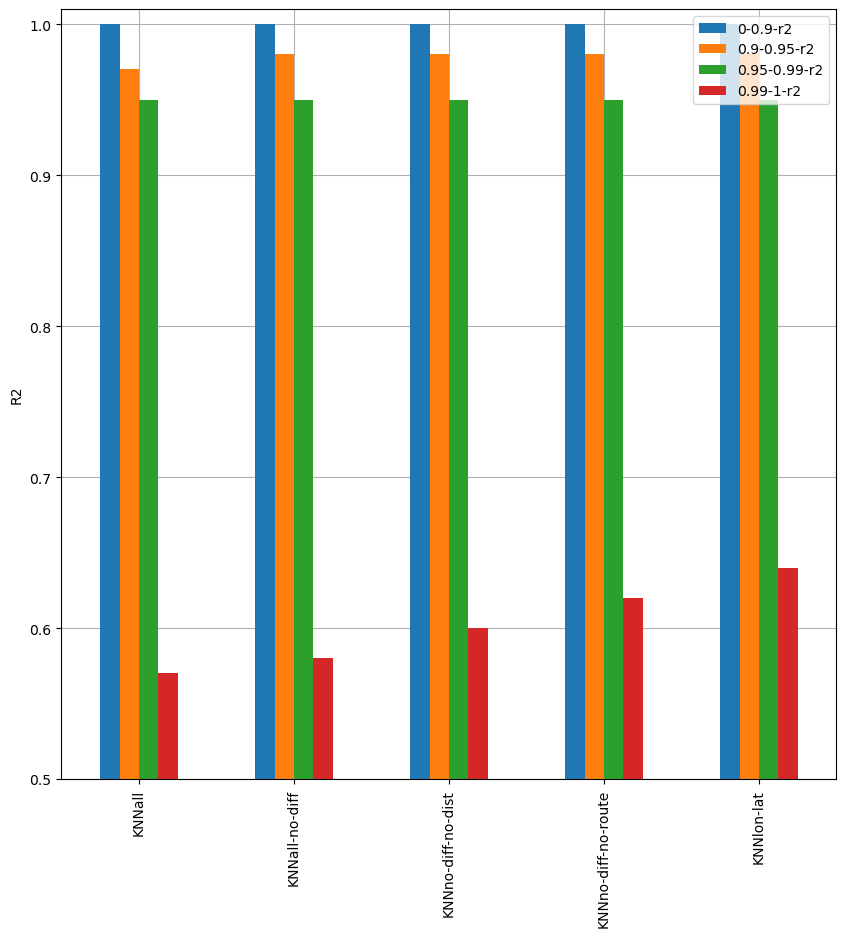

In [130]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.5,1.01])
ax.set_axisbelow(True)

In [586]:
%%time
X_all, y_all = format_data(od_time_quebec,od_timeff_quebec,od_dist_quebec,nodes)

hdf = pd.DataFrame()
metrics = pd.DataFrame()
for param in [('50',50), ('100',100), ('150',150),('200',200),('250',250),('300',300)]:
    X_train, X_test, y_train, y_test = train_test_split( X_all, y_all, test_size=1-(param[1]**2)/len(centroid)**2, random_state=42)
    model_name = 'KNN'+str(param[0])
    print(model_name)
    columns = X_train.columns[[0,1,2,3]].values
    neigh = KNeighborsRegressor(weights='distance',algorithm='ball_tree', n_neighbors=5,)
    neigh.fit(X_train[columns].values, y_train['residual'].values)
    pred_res = neigh.predict(X_test[columns].values)
    
    predictions = y_test['time_ff'] - pred_res
    errors = abs(predictions - y_test['time'])
    MAPE = errors/y_test['time']

    x = y_test['time'].values/60
    y = predictions/60
    regr = linear_model.LinearRegression(fit_intercept=False)#

    regr.fit(x[:, np.newaxis], y)
    y_pred = regr.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    slope = regr.coef_[0]
    intercept=0


    hdf[model_name] = x-y
    sigma = np.std(x-y)
    mean = np.mean(x - y)
    median =np.median(x - y)

    metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
    metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
    metrics.loc[model_name,'r2'] = r2
    metrics.loc[model_name,'slope'] = slope
    metrics.loc[model_name,'diff_mean'] = mean
    metrics.loc[model_name,'diff_median'] = median
    metrics.loc[model_name,'diff_STD'] = sigma

    quant = [0,0.9,0.95,0.99,1]
    for i in range(len(quant)-1):
        cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
        yw = predictions[cond]/60
        xw = y_test[cond]['time'].values/60
        regr = linear_model.LinearRegression(fit_intercept=True)#
        regr.fit(xw[:, np.newaxis], yw)
        y_predw = regr.predict(xw[:, np.newaxis])
        r2 = r2_score(yw, y_predw)
        regr.fit(xw[:, np.newaxis], yw)
        slopew = regr.coef_[0]
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)



KNN50
KNN100
KNN150
KNN200
KNN250
KNN300
CPU times: user 5min 22s, sys: 4.1 s, total: 5min 26s
Wall time: 5min 16s


In [587]:
metrics

,MAE,MAPE,r2,slope,diff_mean,diff_median,diff_STD,0-0.9-slope,0-0.9-r2,0.9-0.95-slope,0.9-0.95-r2,0.95-0.99-slope,0.95-0.99-r2,0.99-1-slope,0.99-1-r2
KNN50,2.11,9.528949,0.941493,0.997487,-0.235747,-0.148768,3.616929,0.987629,0.98,0.909537,0.86,0.823782,0.74,0.366697,0.24
KNN100,1.54,7.041078,0.964998,0.999777,-0.188952,-0.079163,2.802915,0.994795,0.99,0.949046,0.94,0.884486,0.85,0.429537,0.42
KNN150,1.25,5.760967,0.975453,0.998366,-0.101798,-0.035890,2.348488,0.995653,0.99,0.965508,0.96,0.910949,0.91,0.552604,0.54
KNN200,1.08,5.010392,0.980687,0.998621,-0.079718,-0.027556,2.085650,0.996485,1.00,0.975747,0.97,0.945090,0.94,0.589978,0.57
KNN250,0.95,4.478720,0.984874,0.998244,-0.051435,-0.018184,1.846063,0.997048,1.00,0.980792,0.98,0.959535,0.95,0.643190,0.64
KNN300,0.86,4.082979,0.987275,0.998036,-0.036342,-0.014985,1.693309,0.997058,1.00,0.982857,0.98,0.966134,0.96,0.690152,0.68


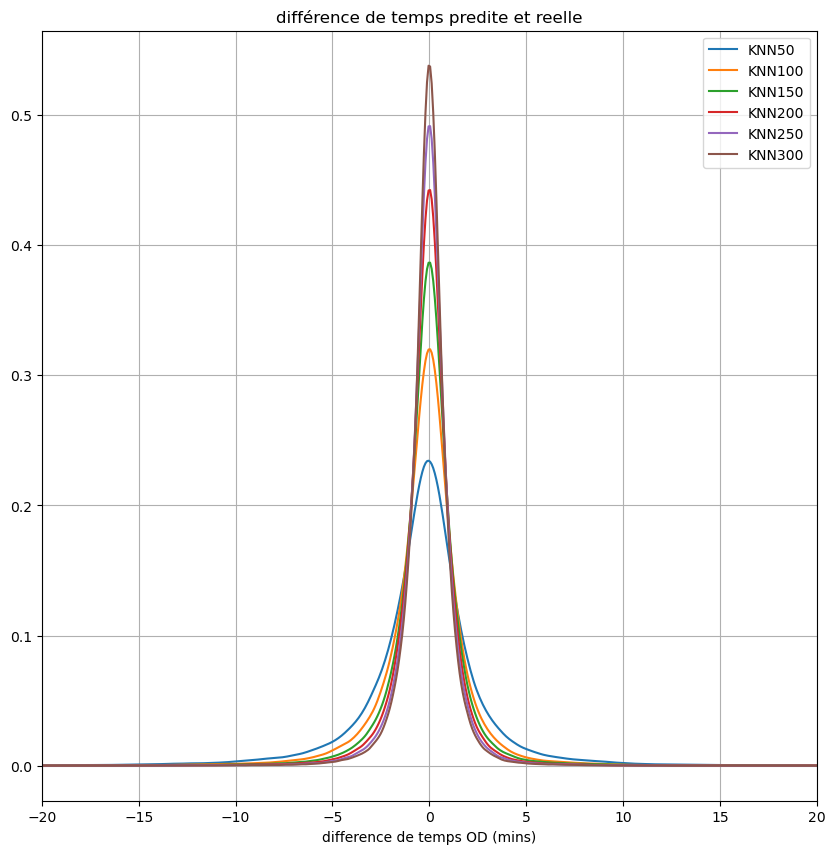

In [590]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name].dropna())
    plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
plt.legend(hdf.columns)
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

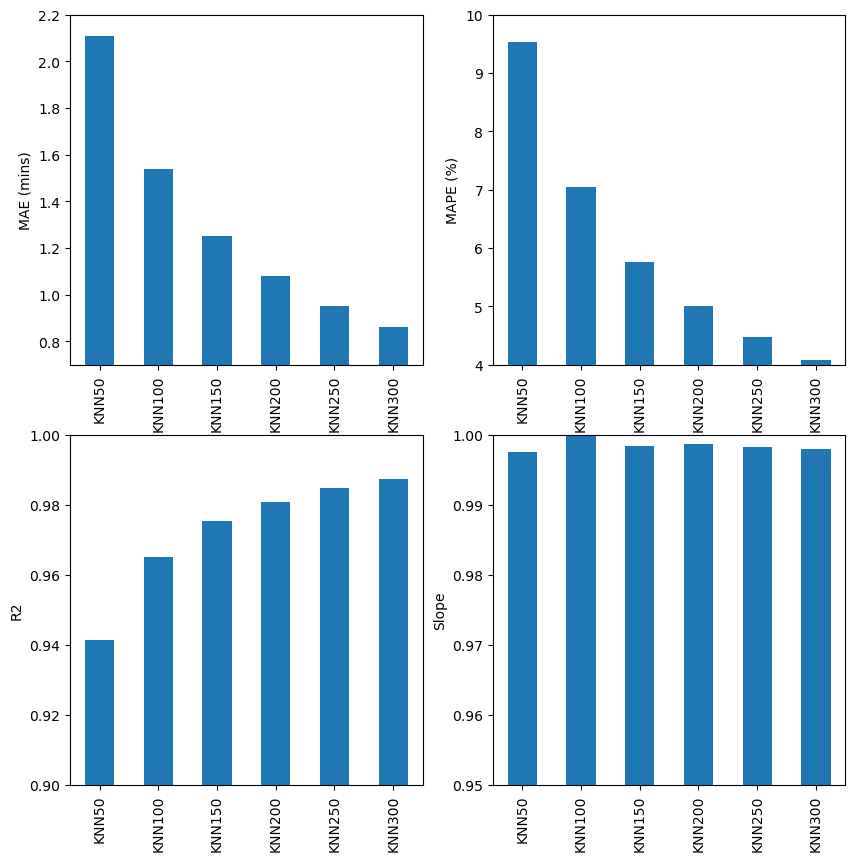

In [608]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)',ylim=[0.7,2.2])
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)',ylim=[4,10])
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2',ylim=[0.9,1])
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.95,1])
plt.show()

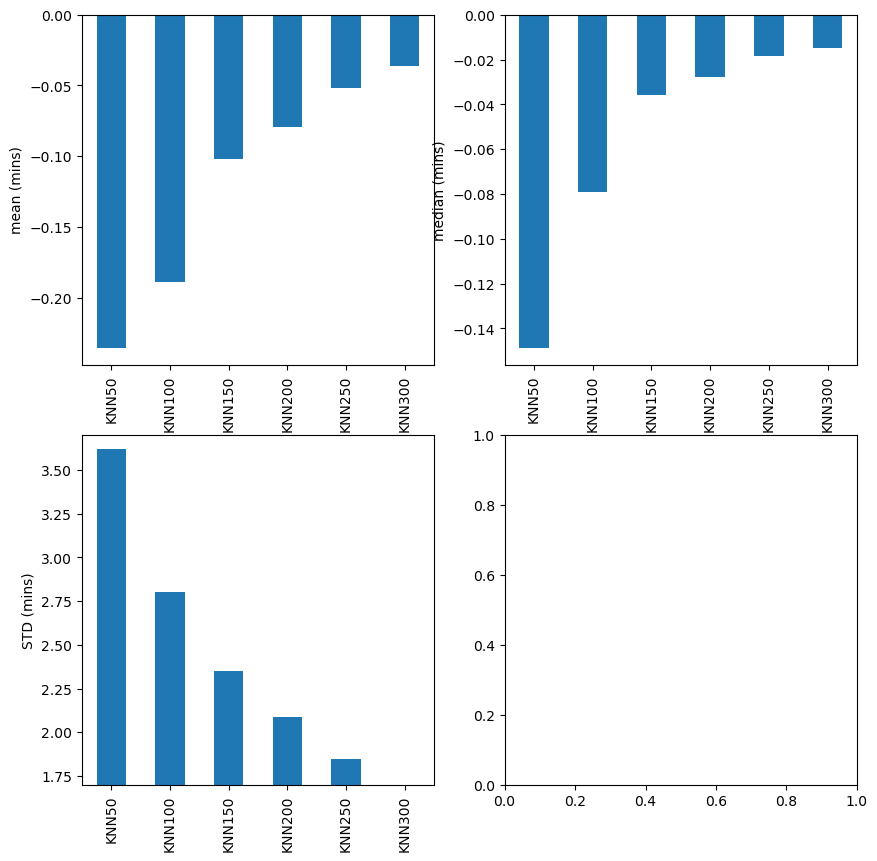

In [614]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)',ylim=[1.7,3.7])
plt.show()

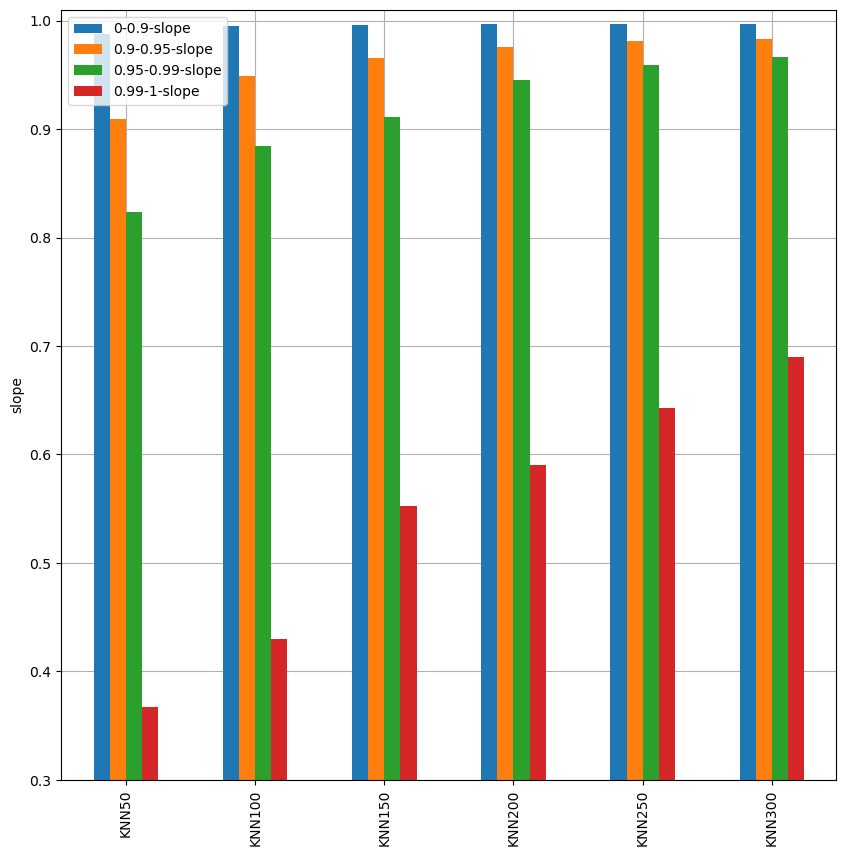

In [617]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.3,1.01])

ax.set_axisbelow(True)

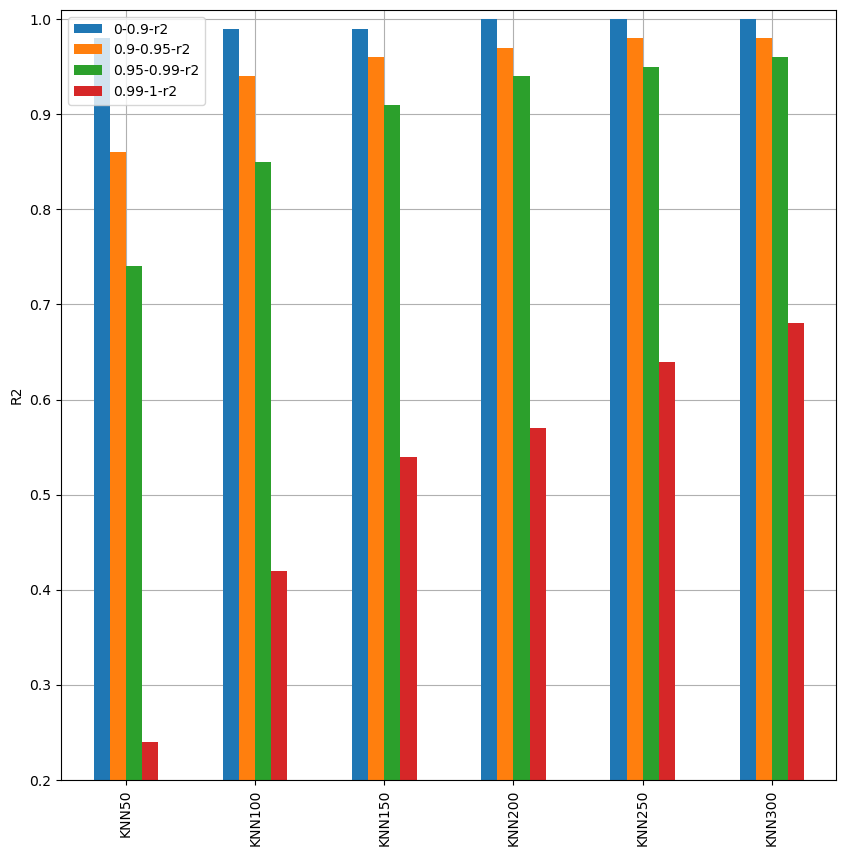

In [622]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.2,1.01])
ax.set_axisbelow(True)

In [1072]:
# variogramme pour changer la fonction weight ou tester des fonctions.
# utiliser un model et un residue. regarder varuigram sur les residue
# Entrainer sur Y  = Dijktra_20kmh - dijktra_reelle (prendre la vitesse moyenmne sur tout le reseau.)

# Variogram

In [30]:
def get_df(od_time,od_timeff,od_dist,nodes):
    df = od_time.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time'})
    routing_dict = od_dist.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'dist'})['dist'].to_dict()
    timeff_dict = od_timeff.stack().reset_index().rename(columns={'level_0':'origin','level_1':'destination',0:'time_ff'})['time_ff'].to_dict()
    geom_dict  = nodes['geometry'].to_dict()
    df['o_geometry'] = df['origin'].apply(lambda x: geom_dict.get(x))
    df['d_geometry'] = df['destination'].apply(lambda x: geom_dict.get(x))
    df['o_lon'] = df['o_geometry'].apply(lambda p: p.x)
    df['o_lat'] = df['o_geometry'].apply(lambda p: p.y)
    df['d_lon'] = df['d_geometry'].apply(lambda p: p.x)
    df['d_lat'] = df['d_geometry'].apply(lambda p: p.y)
    df['distance'] = ((df['o_lon']-df['d_lon'])**2 + (df['o_lat']-df['d_lat'])**2)**0.5
    df['route_distance'] = df.index.map(routing_dict.get)
    df['time_ff'] = df.index.map(timeff_dict.get)
    df['residual'] = df['time_ff']-df['time']
    df['lat_diff'] = df['o_lat']-df['d_lat']
    df['lon_diff'] = df['o_lon']-df['d_lon']
    return df

In [31]:
df = get_df(od_time_quebec,od_timeff_quebec,od_dist_quebec,nodes)

In [32]:
nbrs = NearestNeighbors(n_neighbors=6, algorithm='ball_tree').fit(df[['o_lon','o_lat','d_lon','d_lat']].values)
indices =  nbrs.kneighbors(df[['o_lon','o_lat','d_lon','d_lat']],return_distance=False)
indices = pd.DataFrame(indices)
#distances = pd.DataFrame(distances)
indices = pd.DataFrame(indices.stack(), columns=['index_nn']).reset_index().rename(
    columns={'level_0': 'ix_one', 'level_1': 'rank'})



/Users/simonboivin/opt/anaconda3/envs/wt/lib/python3.10/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but NearestNeighbors was fitted without feature names
  warnings.warn(


In [33]:
# drop duplicates (if 100 is neigh to 1, 1 will be neigh to 100, remove all values like that)
# as the index are sorted, index_nn should always be larger than ix_one
indices = indices.loc[(indices['index_nn']>indices['ix_one']).values]

In [34]:
#get euclidien distance (knn distance was wrong (or i applied it wrong))

geom_dict = {i:ls for i, ls in enumerate(df[['o_lon','o_lat','d_lon','d_lat']].values)}
indices['geom_one'] = indices['ix_one'].apply(lambda x: geom_dict.get(x))
indices['geom_nn'] = indices['index_nn'].apply(lambda x: geom_dict.get(x))
def get_dist(A,B):
    dist=[]
    for a,b in zip(A,B):
        dist.append(((a[0]-b[0])**2 + (a[1]-b[1])**2 + (a[2]-b[2])**2 +(a[3]-b[3])**2)**0.5)
    return dist
indices['distance'] = get_dist(indices['geom_one'],indices['geom_nn'])

In [64]:
res_dict = df['residual'].to_dict()
indices['res_one'] = indices['ix_one'].apply(lambda x: res_dict.get(x))
indices['res_nn'] = indices['index_nn'].apply(lambda x: res_dict.get(x))

In [65]:
# difference en variance (time_one-time_ff) - (time_nn-time_ff) **2
indices['res_diff'] = (indices['res_one']-indices['res_nn'])**2

<AxesSubplot: ylabel='Frequency'>

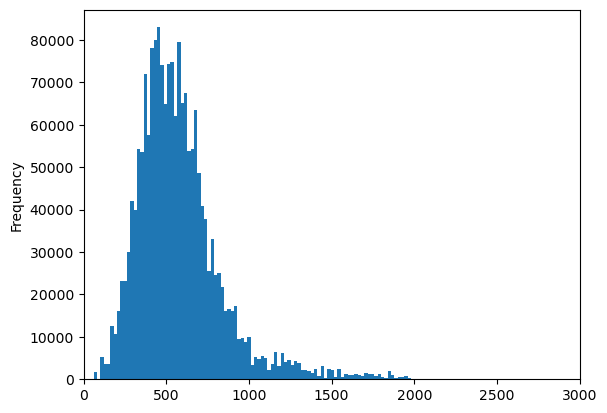

In [66]:
bins=np.linspace(0,2000,100)
indices['distance'].plot.hist(bins=bins,xlim=[0,3000])


In [83]:
bins=500
bins_vols = int(np.ceil(len(indices)/bins))
bins_list = list(range(bins)) * bins_vols
bins_list = bins_list[0:len(indices)]
bins_list.sort()

In [84]:
indices = indices.sort_values('distance')
indices['bins'] = bins_list

In [85]:
try:
    indices = indices.drop(columns=['geom_one','geom_nn'])
except:
    pass


Semivariogram(distanceh) = 0.5 * average((valuei – valuej)2) <br>
meme formule ici <br>
pro.arcgis.com/fr/pro-app/latest/tool-reference/3d-analyst/how-kriging-works.htm.<br>

semivariance
𝛾(ℎ)=1/2𝑁(ℎ)∗∑𝑖=1𝑁(ℎ)(𝑥)**2
notre x est deja sqaure

In [86]:
gdf = indices.groupby('bins')[['res_diff']].agg(np.mean)
gdf = gdf/2
bins_name = indices.groupby('bins')['distance'].agg(np.mean).to_dict()
gdf['distance'] = gdf.index.map(bins_name.get) #name bins


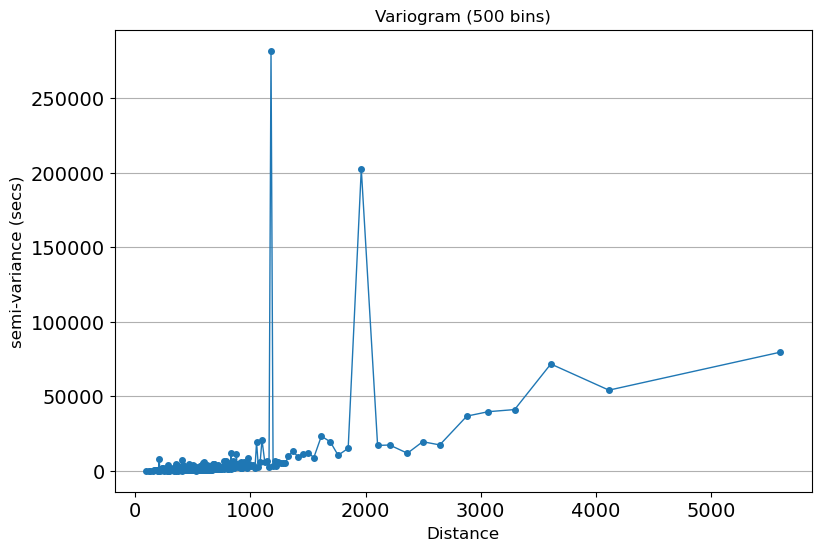

In [87]:
%matplotlib inline
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values

ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'major',linestyle='-',axis='y')
ax.set_axisbelow(True)

plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram ({b} bins)'.format(b=bins),fontsize=12)
plt.show()

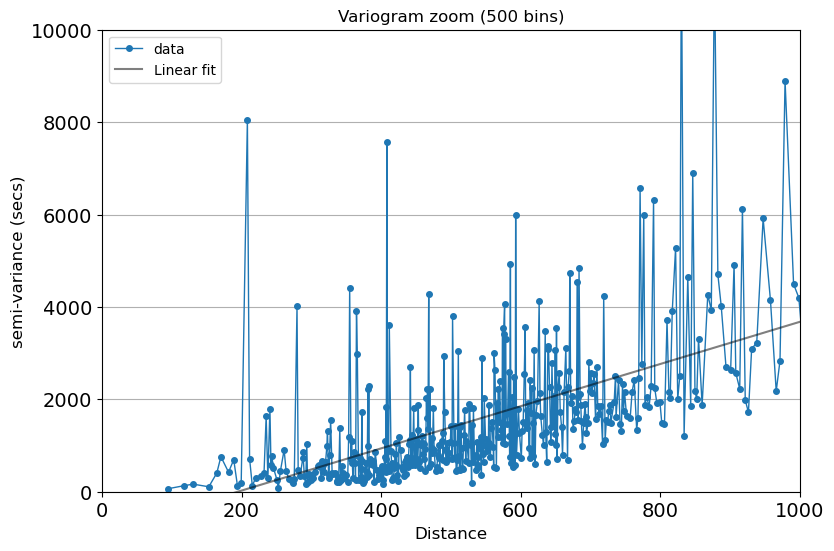

In [88]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values


ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'major',linestyle='-',axis='y')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

plt.ylim([0,10000])
plt.xlim([0,1000])


regr = linear_model.LinearRegression(fit_intercept=True)#
regr.fit(np.array(x[0:gdf[gdf['distance']<=1000].index[-1]])[:, np.newaxis], y[0:gdf[gdf['distance']<=1000].index[-1]])
slope = regr.coef_[0]
intercept = regr.intercept_
x_fit = np.linspace(0,4000,100)
x_lin = x_fit
y_lin = x_fit*slope+intercept
plt.plot(x_fit,x_fit*slope+intercept,'k',alpha=0.5)
plt.legend(['data','Linear fit'])

plt.show()

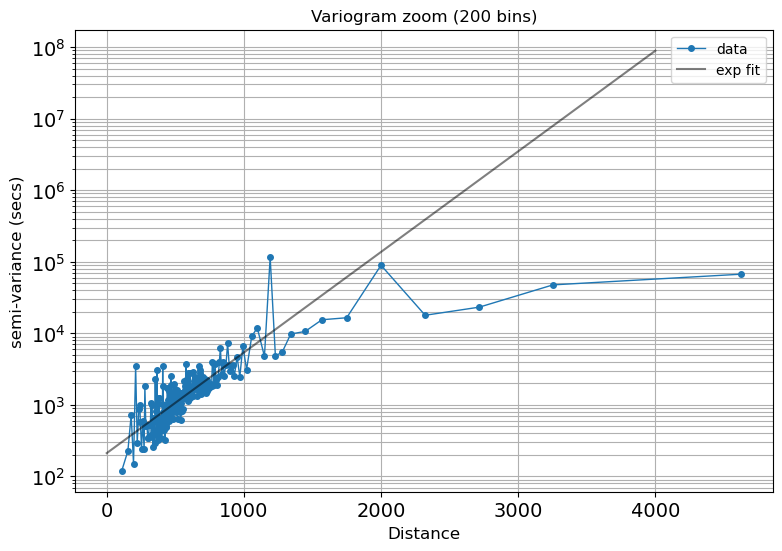

In [75]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values

x_fit = np.array(x[0:gdf[gdf['distance']<=1000].index[-1]])[:, np.newaxis]
y_fit = np.log10(y[0:gdf[gdf['distance']<=1000].index[-1]])

ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

#plt.ylim([100,10000])
#plt.xlim([0,1000])

regr = linear_model.LinearRegression(fit_intercept=True)#
regr.fit(x_fit,y_fit)
slope = regr.coef_[0]
cst=1/np.log10(np.exp(1))
intercept = regr.intercept_
slope = slope*cst
intercept=intercept*cst
x_fit = np.linspace(0,4000,100)
plt.plot(x_fit,np.exp(x_fit*slope+intercept),'k',alpha=0.5)
plt.yscale('log')
plt.legend(['data','exp fit'])


plt.show()

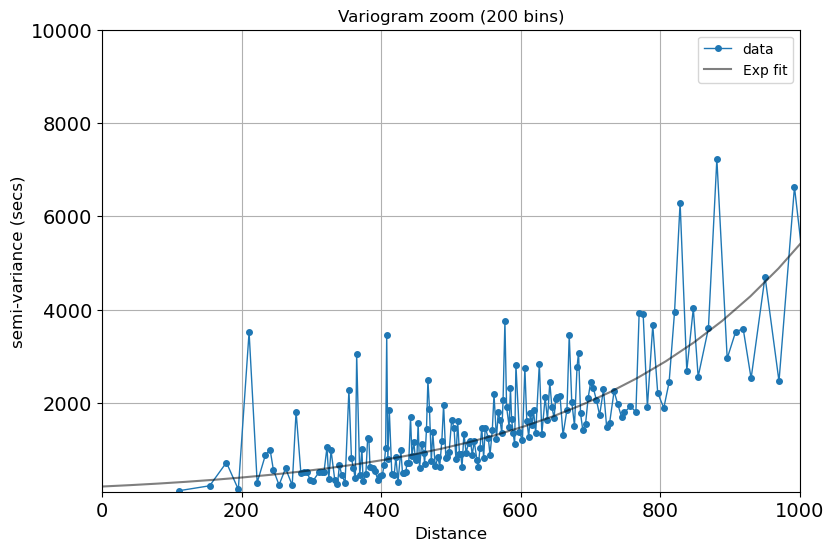

In [76]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values

x_fit = np.array(x[0:gdf[gdf['distance']<=1000].index[-1]])[:, np.newaxis]
y_fit = np.log10(y[0:gdf[gdf['distance']<=1000].index[-1]])

ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

plt.ylim([100,10000])
plt.xlim([0,1000])

regr = linear_model.LinearRegression(fit_intercept=True)#
regr.fit(x_fit,y_fit)
slope = regr.coef_[0]
cst=1/np.log10(np.exp(1))
intercept = regr.intercept_
slope = slope*cst
intercept=intercept*cst
x_fit = np.linspace(0,4000,100)
plt.plot(x_fit,np.exp(x_fit*slope+intercept),'k',alpha=0.5)
x_exp = x_fit
y_exp = np.exp(x_fit*slope+intercept)

plt.legend(['data','Exp fit'])

plt.show()

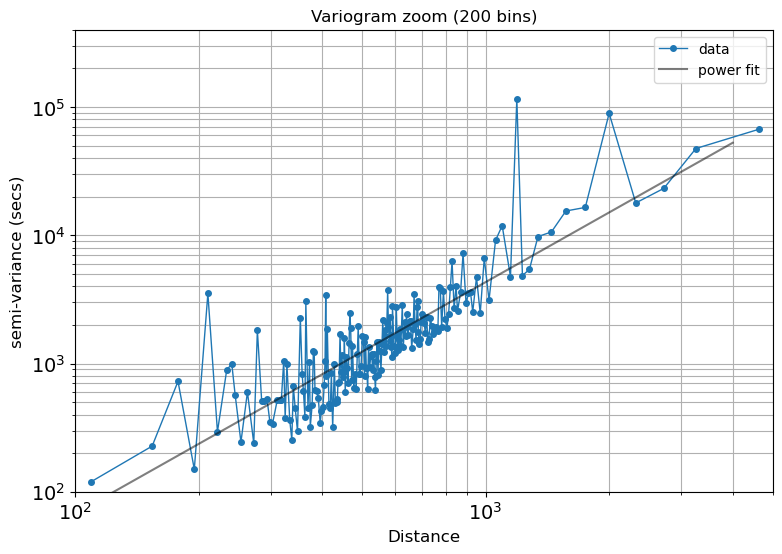

1.804988698036225 -1.780021034150011


In [77]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values

x_fit = np.log10(np.array(x))[:, np.newaxis]
y_fit = np.log10(y)

ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

plt.ylim([100,400000])
plt.xlim([100,5000])

regr = linear_model.LinearRegression(fit_intercept=True)#
regr.fit(x_fit,y_fit)
slope = regr.coef_[0]
intercept = regr.intercept_

x_fit = np.linspace(0,4000,100)
plt.plot(x_fit,(x_fit)**(slope)*10**intercept,'k',alpha=0.5)

x_power = x_fit
y_power = (x_fit)**(slope)*10**intercept
plt.yscale('log')
plt.xscale('log')
plt.legend(['data','power fit'])

plt.show()
print(slope,intercept)

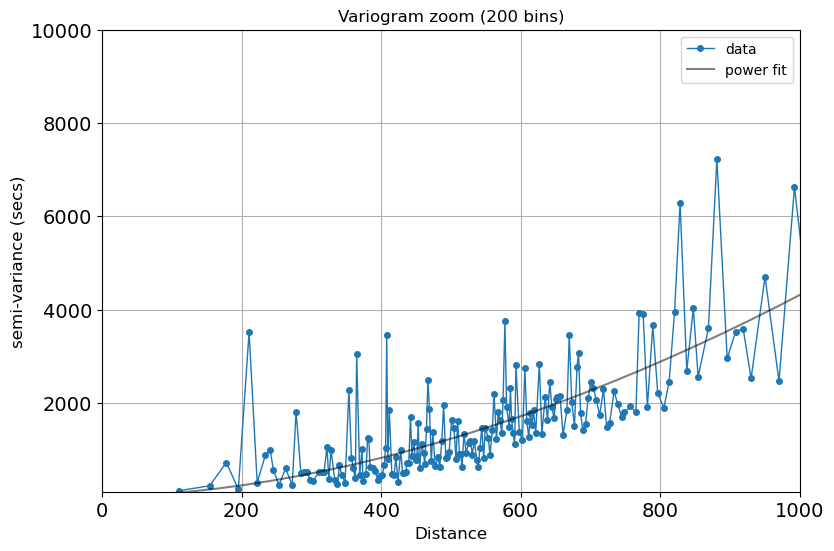

In [78]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values

x_fit = np.log10(np.array(x))[:, np.newaxis]
y_fit = np.log10(y)

ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

plt.ylim([100,10000])
plt.xlim([0,1000])

regr = linear_model.LinearRegression(fit_intercept=True)#
regr.fit(x_fit,y_fit)
slope = regr.coef_[0]
intercept = regr.intercept_

x_fit = np.linspace(0,4000,100)
plt.plot(x_fit,(x_fit)**(slope)*10**intercept,'k',alpha=0.5)
plt.legend(['data','power fit'])

plt.show()

In [79]:
slope

1.804988698036225

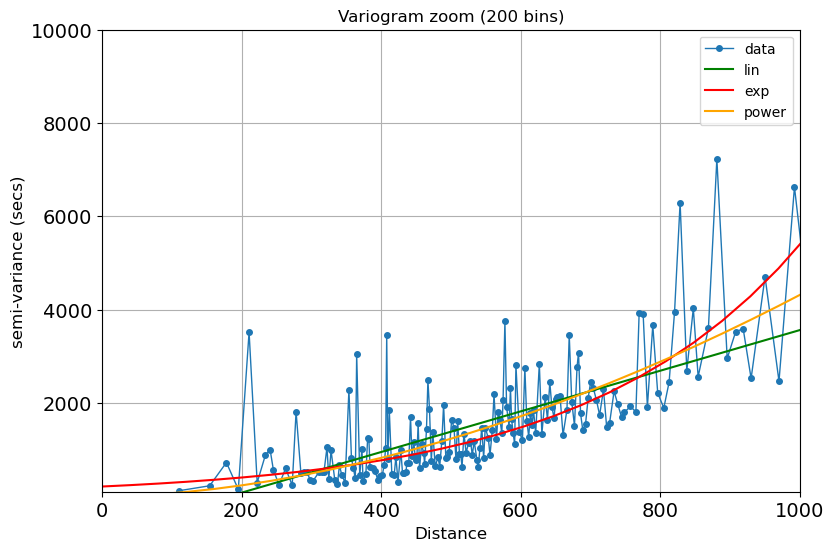

In [80]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values



ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)

plt.ylim([100,10000])
plt.xlim([0,1000])


x_fit = np.linspace(0,1000,100)
plt.plot(x_lin,y_lin,'green',alpha=1)
plt.plot(x_exp,y_exp,'red',alpha=1)
plt.plot(x_power,y_power,'orange',alpha=1)
plt.legend(['data','lin','exp','power'])

plt.show()

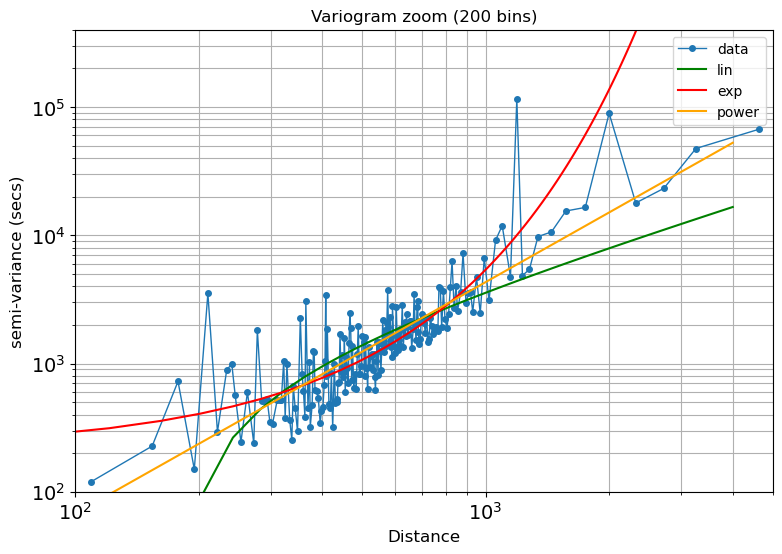

In [81]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values



ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)


plt.ylim([100,400000])
plt.xlim([100,5000])
x_fit = np.linspace(0,1000,100)
plt.plot(x_lin,y_lin,'green',alpha=1)
plt.plot(x_exp,y_exp,'red',alpha=1)
plt.plot(x_power,y_power,'orange',alpha=1)
plt.legend(['data','lin','exp','power'])
plt.yscale('log')
plt.xscale('log')

plt.show()

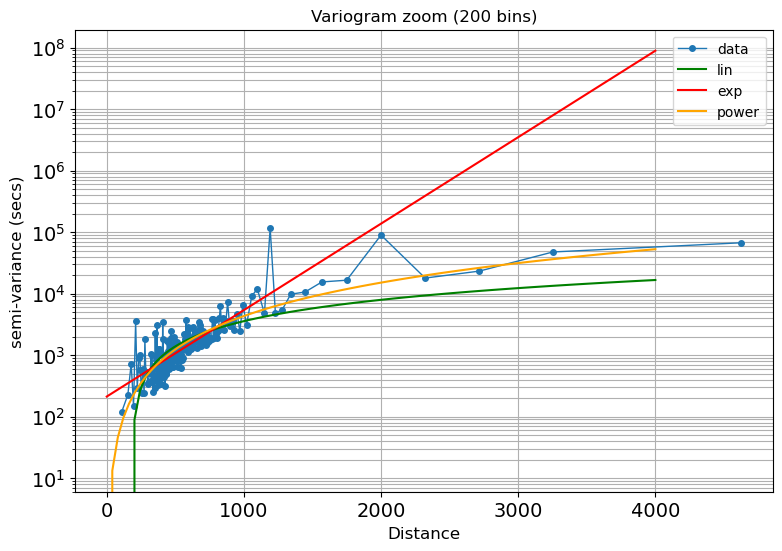

In [51]:
f, ax = plt.subplots(figsize=(9,6))
x=gdf['distance']
y=gdf['res_diff'].values



ax.plot(x, y,'-o', linewidth=1, markersize=4)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.grid(True,'both',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlabel('Distance',fontsize=12)
plt.ylabel('semi-variance (secs)',fontsize=12)
plt.title('Variogram zoom ({b} bins)'.format(b=bins),fontsize=12)



x_fit = np.linspace(0,1000,100)
plt.plot(x_lin,y_lin,'green',alpha=1)
plt.plot(x_exp,y_exp,'red',alpha=1)
plt.plot(x_power,y_power,'orange',alpha=1)
plt.legend(['data','lin','exp','power'])
plt.yscale('log')

plt.show()

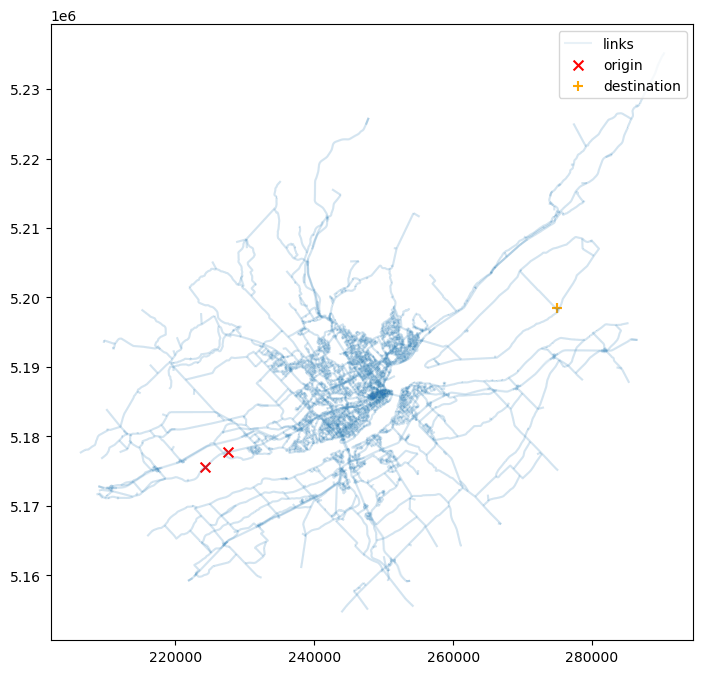

In [1115]:
%matplotlib inline
f, ax = plt.subplots(figsize=(10,8))
links.plot(ax=ax,alpha=0.1)
nodes.loc[df.loc[[574134,637854]]['origin'].values].plot(ax=ax,color='red',marker='x',markersize=50)
nodes.loc[df.loc[[574134,637854]]['destination'].values].plot(ax=ax,color='orange',marker='+',markersize=50)

plt.legend(['links','origin','destination'])

In [142]:
xx = np.linspace(0,1000,1000)

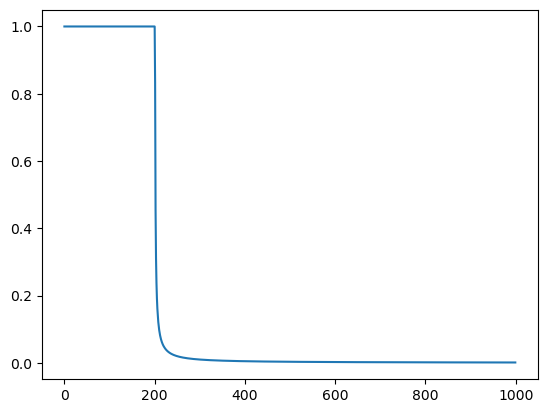

In [144]:
plt.plot(1/np.clip(xx-200,1,np.inf))

In [145]:
%%time
hdf = pd.DataFrame()
metrics = pd.DataFrame()
def func1(x):
    return 1/x
def func2(x):
    return 1/(np.clip(x-200,1,np.inf))
def func3(x):
    return 1/(x**1.84)
def func4(x):
    return 1/(x**2)
def func5(x):
    return 1/(x**3)
def func6(x):
    return 1/(x**4)
def func7(x):
    return 1/(np.exp(0.00344*x)-1)


for param in [('1/x',func1),('clip',func2),('1/x1.84',func3),('1/x2',func4),('1/x3',func5),('1/x4)',func6),('1/exp)',func7)]:
    model_name = 'KNN'+str(param[0])
    print(model_name)
    columns = X_train.columns[[0,1,2,3]].values
    neigh = KNeighborsRegressor(weights=param[1],algorithm='ball_tree', n_neighbors=5,)
    neigh.fit(X_train[columns].values, y_train['residual'].values)
    pred_res = neigh.predict(X_test[columns].values)
    
    predictions = y_test['time_ff'] - pred_res
    errors = abs(predictions - y_test['time'])
    MAPE = errors/y_test['time']

    x = y_test['time'].values/60
    y = predictions/60
    regr = linear_model.LinearRegression(fit_intercept=False)#

    regr.fit(x[:, np.newaxis], y)
    y_pred = regr.predict(x[:, np.newaxis])
    r2 = r2_score(y, y_pred)
    slope = regr.coef_[0]
    intercept=0


    hdf[model_name] = x-y
    sigma = np.std(x-y)
    mean = np.mean(x - y)
    median =np.median(x - y)

    metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
    metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
    metrics.loc[model_name,'r2'] = r2
    metrics.loc[model_name,'slope'] = slope
    metrics.loc[model_name,'diff_mean'] = mean
    metrics.loc[model_name,'diff_median'] = median
    metrics.loc[model_name,'diff_STD'] = sigma

    quant = [0,0.9,0.95,0.99,1]
    for i in range(len(quant)-1):
        cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
        yw = predictions[cond]/60
        xw = y_test[cond]['time'].values/60
        regr = linear_model.LinearRegression(fit_intercept=True)#
        regr.fit(xw[:, np.newaxis], yw)
        y_predw = regr.predict(xw[:, np.newaxis])
        r2 = r2_score(yw, y_predw)
        regr.fit(xw[:, np.newaxis], yw)
        slopew = regr.coef_[0]
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
        metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)



KNNclip
KNN1/x1.84
KNN1/x2
KNN1/x3
KNN1/x4)
KNN1/exp)
CPU times: user 7min 27s, sys: 9.01 s, total: 7min 36s
Wall time: 7min 38s


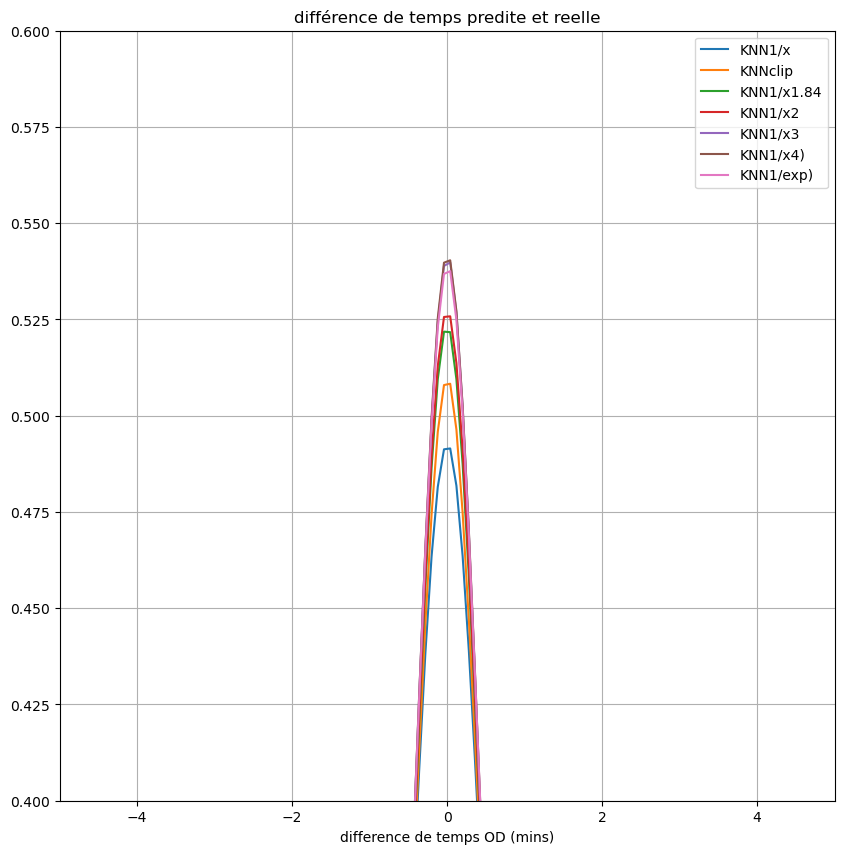

In [146]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name].dropna())
    plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-5,5])
plt.ylim([0.4,0.6])
plt.legend(hdf.columns)
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

In [147]:
metrics

,MAE,MAPE,r2,slope,diff_mean,diff_median,diff_STD,0-0.9-slope,0-0.9-r2,0.9-0.95-slope,0.9-0.95-r2,0.95-0.99-slope,0.95-0.99-r2,0.99-1-slope,0.99-1-r2
KNN1/x,0.95,4.478720,0.984874,0.998244,-0.051435,-0.018184,1.846063,0.997048,1.0,0.980792,0.98,0.959535,0.95,0.643190,0.64
KNNclip,0.93,4.406017,0.985228,0.998336,-0.050501,-0.016270,1.824810,0.997146,1.0,0.981295,0.98,0.961296,0.96,0.651097,0.65
KNN1/x1.84,0.90,4.295373,0.986048,0.998463,-0.046224,-0.015382,1.774415,0.997186,1.0,0.981770,0.98,0.966121,0.96,0.672522,0.65
KNN1/x2,0.90,4.272780,0.986178,0.998498,-0.045384,-0.014556,1.766457,0.997228,1.0,0.981989,0.98,0.967252,0.96,0.677652,0.65
KNN1/x3,0.88,4.201466,0.986553,0.998667,-0.041136,-0.010956,1.743951,0.997443,1.0,0.983685,0.98,0.971676,0.96,0.697549,0.65
KNN1/x4),0.88,4.205909,0.986499,0.998769,-0.038264,-0.009393,1.748700,0.997603,1.0,0.985057,0.98,0.975490,0.96,0.705862,0.64
KNN1/exp),0.89,4.223468,0.985098,0.998682,-0.032890,-0.007080,1.839181,0.997418,1.0,0.985221,0.98,0.978198,0.96,0.717948,0.60


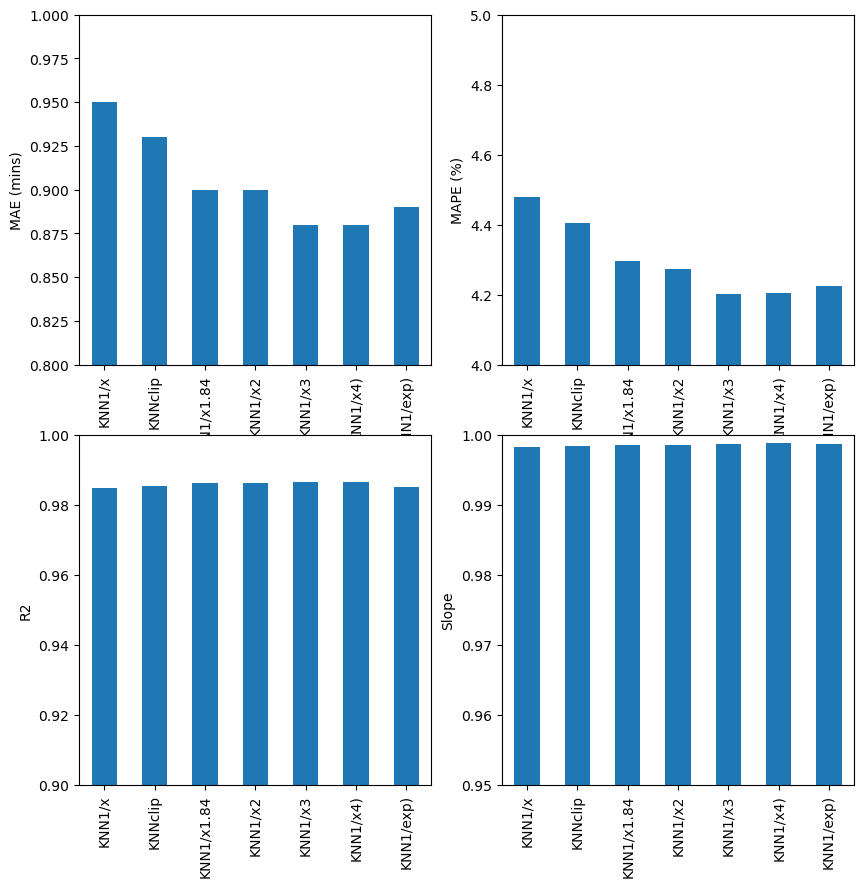

In [148]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)',ylim=[0.8,1])
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)',ylim=[4,5])
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2',ylim=[0.9,1])
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.95,1])
plt.show()

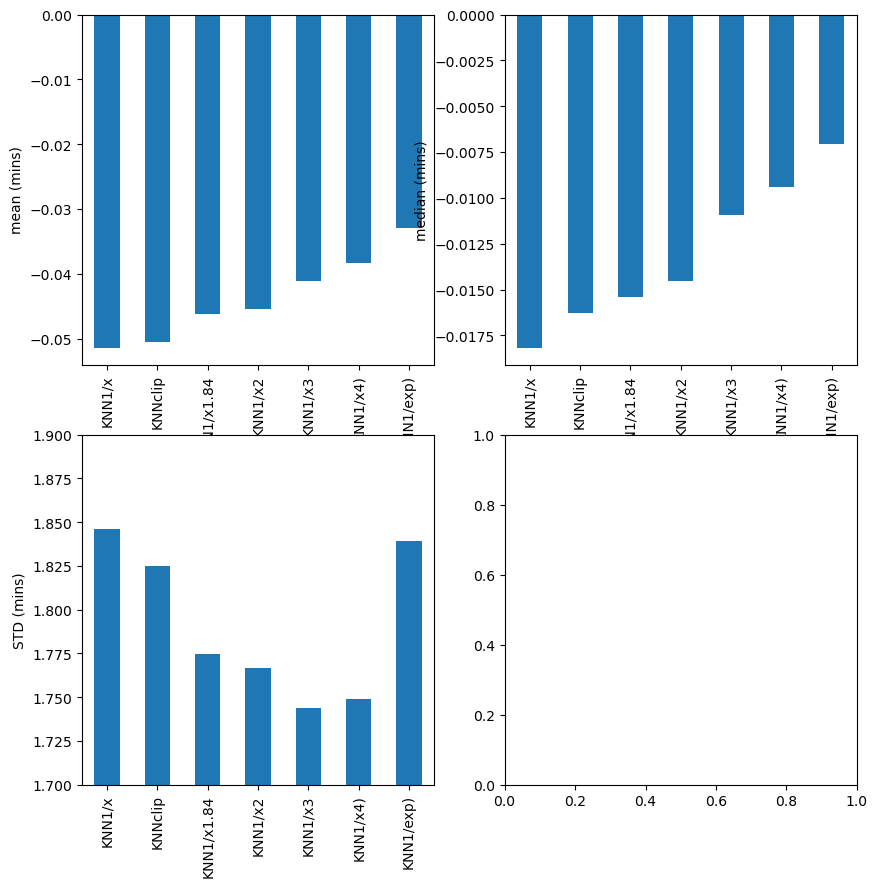

In [149]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)')
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)')
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)',ylim=[1.7,1.9])
plt.show()

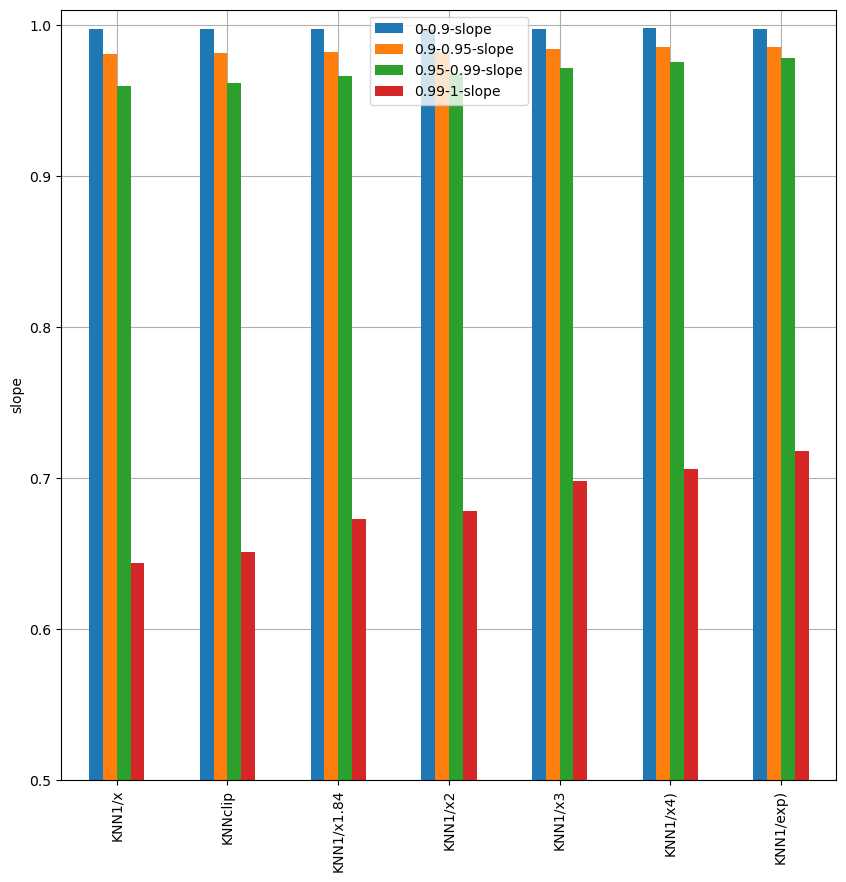

In [150]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0.5,1.02],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.5,1.01])

ax.set_axisbelow(True)

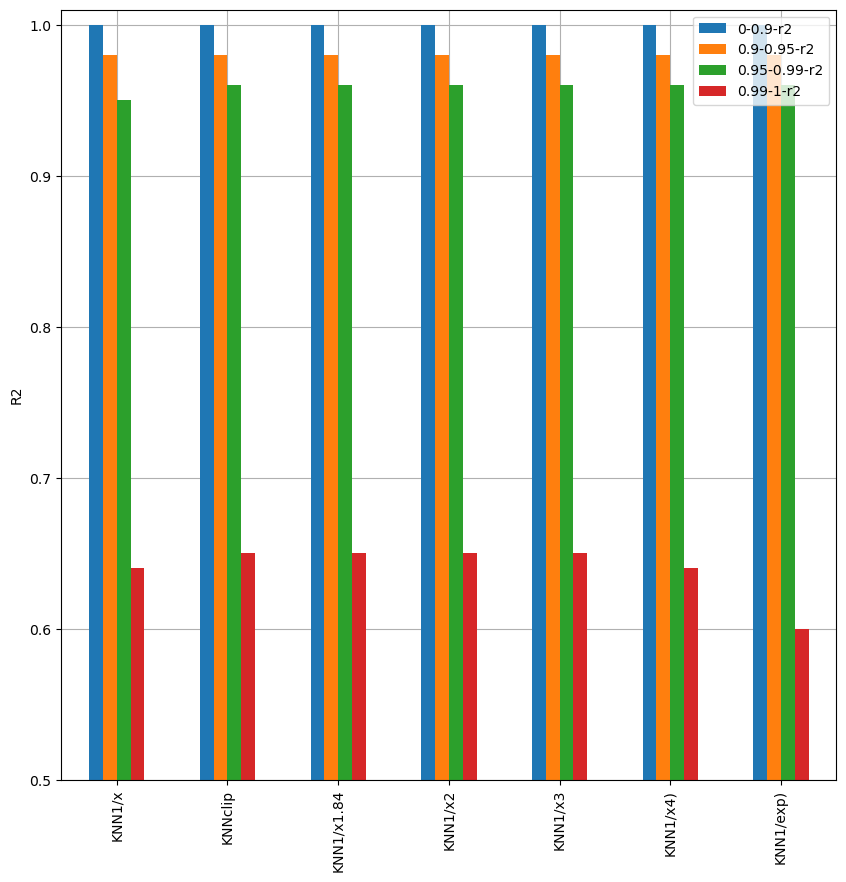

In [151]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.5,1.01])
ax.set_axisbelow(True)

In [ ]:
# Fit sur le modele de vitesse moyenne.
# Juste pour voir si on ammeliore pour vrai
# refaire le variogramme sur les residues seulements..

In [ ]:
# Construire un reseau routier.

# comparaison model FREEFLOW 

In [70]:
%%time
hdf = pd.DataFrame()
metrics = pd.DataFrame()


model_name = 'best_KNN'
print(model_name)
columns = X_train.columns[[0,1,2,3]].values
neigh = KNeighborsRegressor(weights=lambda x: 1/(x**1.82),algorithm='ball_tree', n_neighbors=5,)
neigh.fit(X_train[columns].values, y_train['residual'].values)
pred_res = neigh.predict(X_test[columns].values)

predictions = y_test['time_ff'] - pred_res
errors = abs(predictions - y_test['time'])
MAPE = errors/y_test['time']

x = y_test['time'].values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond]['time'].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)


    
model_name = 'mean_speed'
print(model_name)

predictions = y_test['time_ff'] 
errors = abs(predictions - y_test['time'])
MAPE = errors/y_test['time']

x = y_test['time'].values/60
y = predictions/60
regr = linear_model.LinearRegression(fit_intercept=False)#

regr.fit(x[:, np.newaxis], y)
y_pred = regr.predict(x[:, np.newaxis])
r2 = r2_score(y, y_pred)
slope = regr.coef_[0]
intercept=0


hdf[model_name] = x-y
sigma = np.std(x-y)
mean = np.mean(x - y)
median =np.median(x - y)

metrics.loc[model_name,'MAE'] = round(np.mean(errors)/60, 2)
metrics.loc[model_name,'MAPE'] = 100*np.nanmean(MAPE[np.isfinite(MAPE)])
metrics.loc[model_name,'r2'] = r2
metrics.loc[model_name,'slope'] = slope
metrics.loc[model_name,'diff_mean'] = mean
metrics.loc[model_name,'diff_median'] = median
metrics.loc[model_name,'diff_STD'] = sigma

quant = [0,0.9,0.95,0.99,1]
for i in range(len(quant)-1):
    cond = (errors>=errors.quantile(quant[i])) & (errors<errors.quantile(quant[i+1]))
    yw = predictions[cond]/60
    xw = y_test[cond]['time'].values/60
    regr = linear_model.LinearRegression(fit_intercept=True)#
    regr.fit(xw[:, np.newaxis], yw)
    y_predw = regr.predict(xw[:, np.newaxis])
    r2 = r2_score(yw, y_predw)
    regr.fit(xw[:, np.newaxis], yw)
    slopew = regr.coef_[0]
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-slope'] = slopew
    metrics.loc[model_name,str(quant[i]) + '-'+ str(quant[i+1]) + '-r2'] = round(r2,2)

best_KNN
mean_speed
CPU times: user 1min 6s, sys: 799 ms, total: 1min 6s
Wall time: 1min 5s


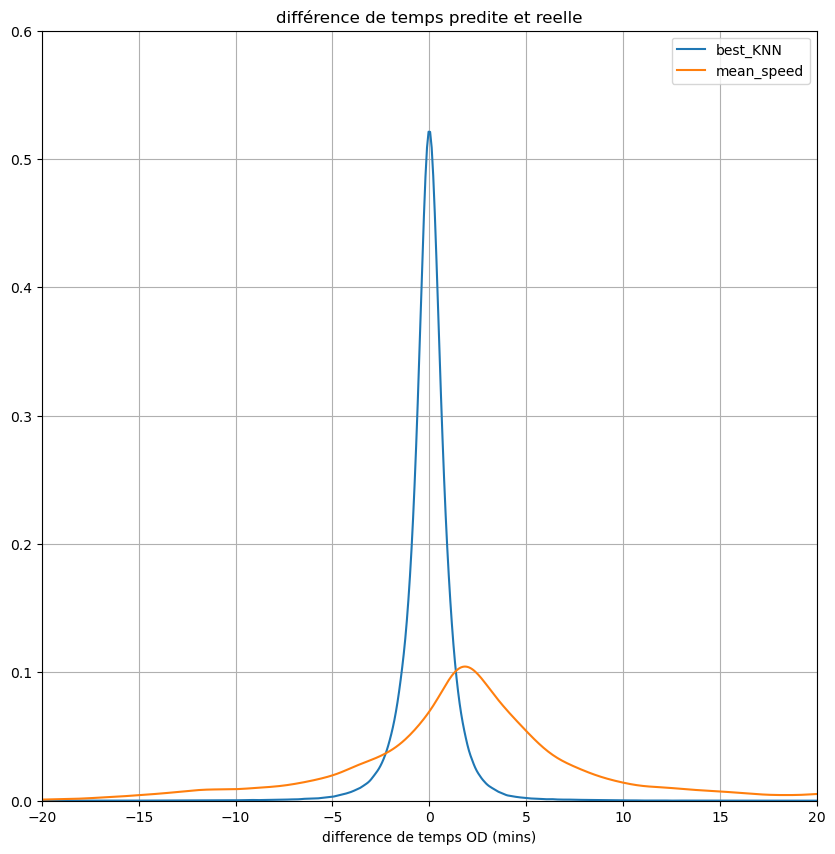

In [79]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(10,10))
import scipy.stats as stats
x=np.linspace(-20, 20, 500)
for name in hdf.columns:
    density = stats.gaussian_kde(hdf[name].dropna())
    plt.plot(x,density(x))
plt.grid(True,'major',linestyle='-',axis='both')
ax.set_axisbelow(True)
plt.xlim([-20,20])
plt.ylim([0,0.6])
plt.legend(hdf.columns)
plt.xlabel('difference de temps OD (mins)')

plt.title('différence de temps predite et reelle')
plt.show()

In [80]:
metrics

,MAE,MAPE,r2,slope,diff_mean,diff_median,diff_STD,0-0.9-slope,0-0.9-r2,0.9-0.95-slope,0.9-0.95-r2,0.95-0.99-slope,0.95-0.99-r2,0.99-1-slope,0.99-1-r2
best_KNN,0.90,4.298463,0.986030,0.998458,-0.046332,-0.01537,1.775520,0.997180,1.00,0.981627,0.98,0.966102,0.96,0.671932,0.65
mean_speed,5.88,23.161289,0.740414,0.891131,2.795063,2.09491,8.162893,1.015896,0.88,0.934154,0.38,1.328793,0.59,0.736159,0.43


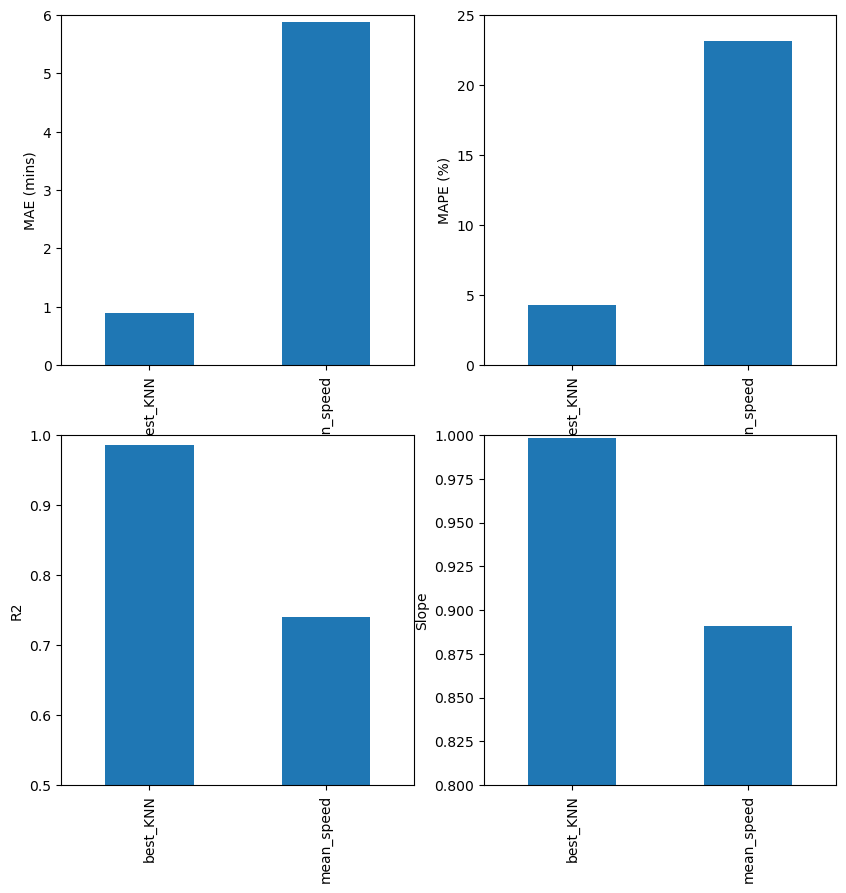

In [85]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['MAE'].plot(kind='bar',ax=ax[0,0],ylabel='MAE (mins)',ylim=[0,6])
metrics['MAPE'].plot(kind='bar',ax=ax[0,1],ylabel='MAPE (%)',ylim=[0,25])
metrics['r2'].plot(kind='bar',ax=ax[1,0],ylabel='R2',ylim=[0.5,1])
metrics['slope'].plot(kind='bar',ax=ax[1,1],ylabel='Slope',ylim=[0.8,1])
plt.show()

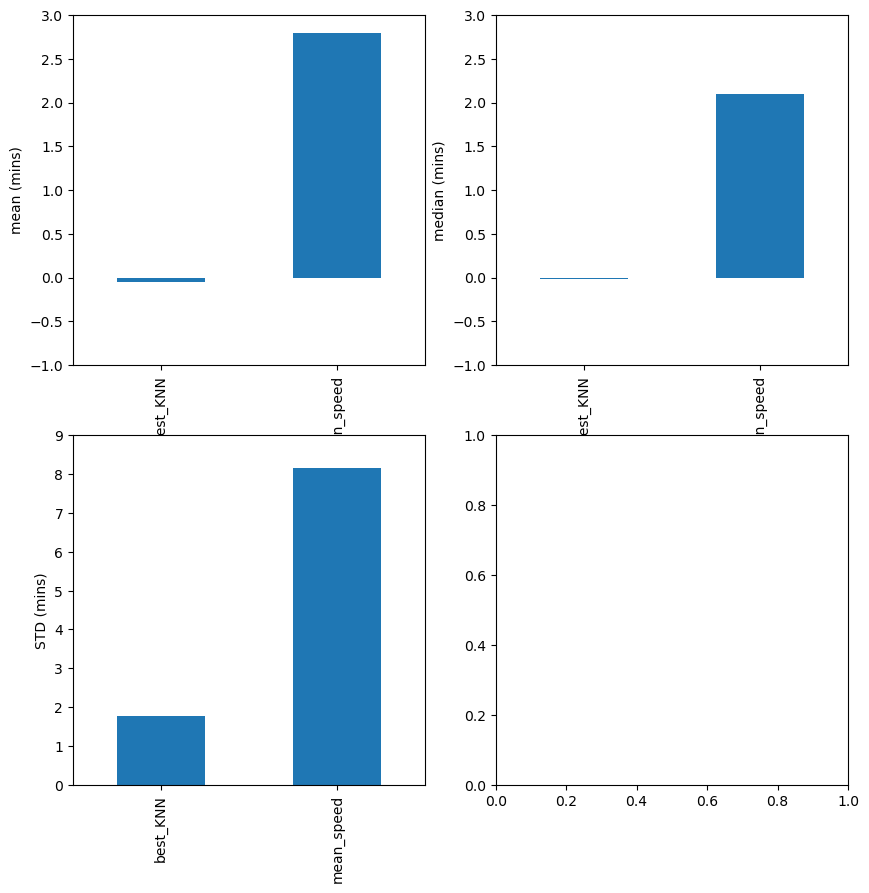

In [91]:
fig, ax = plt.subplots(2,2,figsize=(10,10))
metrics['diff_mean'].plot(kind='bar',ax=ax[0,0],ylabel='mean (mins)',ylim=[-1,3])
metrics['diff_median'].plot(kind='bar',ax=ax[0,1],ylabel='median (mins)',ylim=[-1,3])
metrics['diff_STD'].plot(kind='bar',ax=ax[1,0],ylabel='STD (mins)',ylim=[0,9])
plt.show()

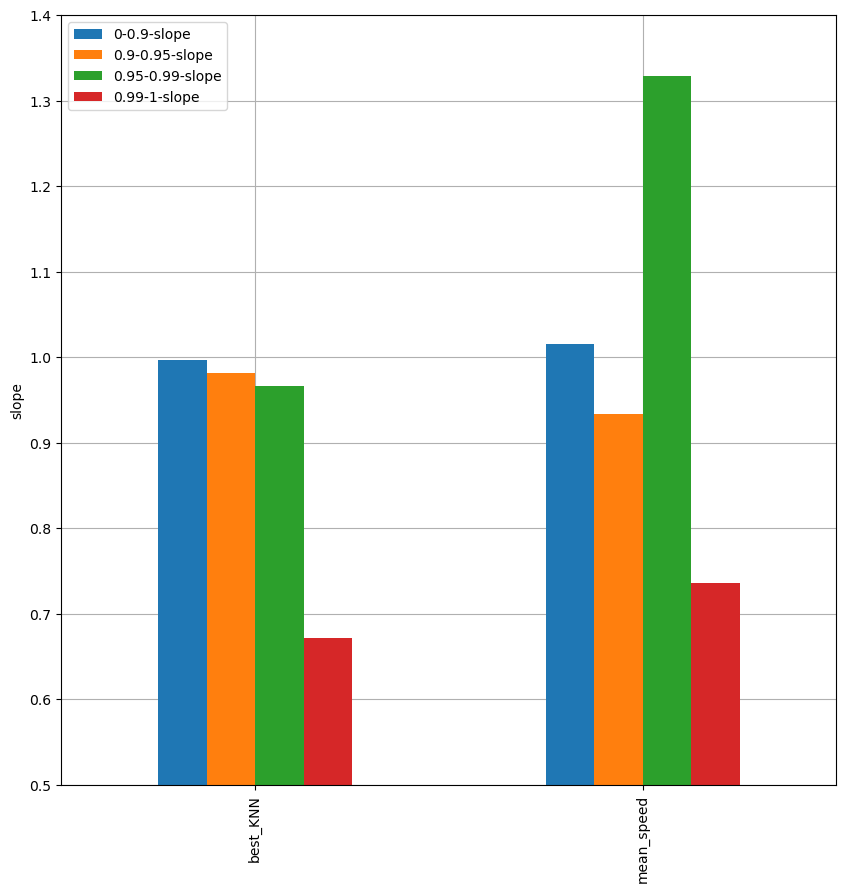

In [97]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-slope' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0.5,2],ylabel='slope')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0.5,1.4])

ax.set_axisbelow(True)

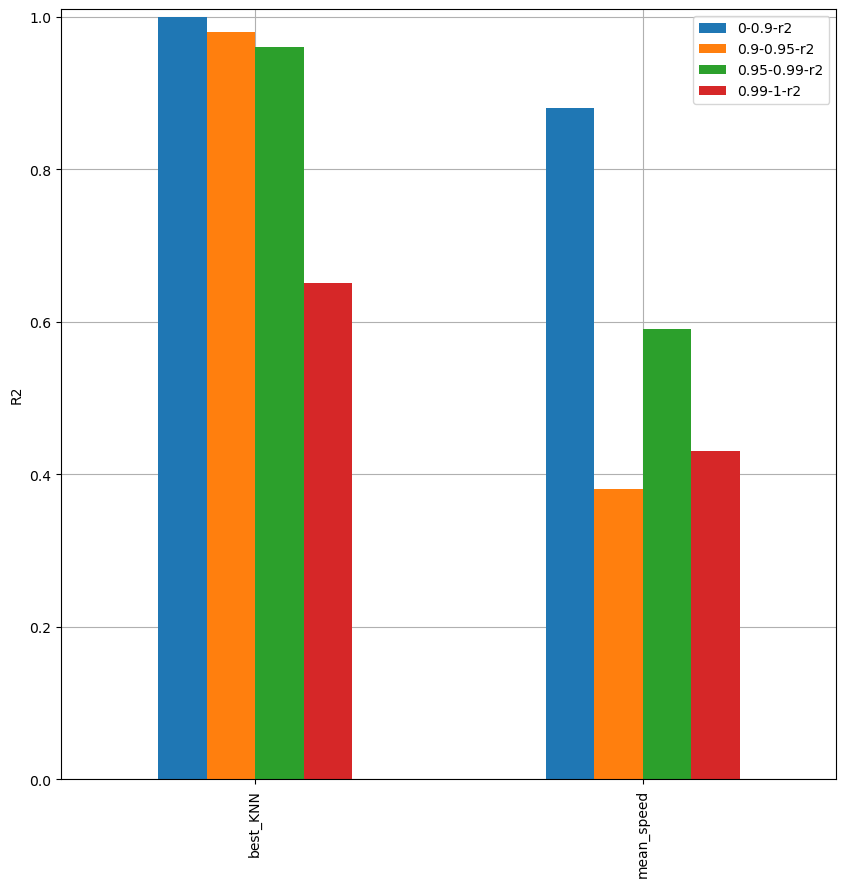

In [98]:
fig, ax = plt.subplots(figsize=(10,10))

metrics[metrics.columns[['-r2' in col for col in metrics.columns]]].plot(ax=ax,kind='bar',ylim=[0,1],ylabel='R2')
plt.grid(True,'major',linestyle='-',axis='both')
plt.ylim([0,1.01])
ax.set_axisbelow(True)